# Exercise Sheet 3 - Covid-19 Classification using Transfer Learning

- Deep Learning for Computer Vision - Winter Term 2023/24
- Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
- Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal
- Due date: **Tuesday**, Dec 5, before 10:00

## Time Required to Solve this Exercise Sheet

As you will train deep CNNs on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.

## Topic

In this exercise, you will solve an image classification task from medical imaging: classification in Chest X-Ray images into patients with Covid-19, Pneunomia or Healthy. We will use a subset of the dataset from a kaggle challenge for this. (https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia)

The main focus of this exercise is transfer learning and you will approach the classification task with three different approaches:

    Training ResNets from scratch. (Note that we will use the ResNet implementation from torchvision throughout the exercise).
    Training ResNets pretrained on ImageNet.
    Training ResNets pretrained on RadImageNet, a large radiology dataset.

In addition you can combine these approaches with other methods to improve the model at the end and upload your best solution on a hold-out test set. This is explained in more details at the end of the exercise.

### Hints

In the first part of the exercise you will train ResNets from scratch, analyze the effects of deeper models with small training data and use data augmentations. In the second part, you will solve the same task using pretrained ResNets (from ImageNet - pretrained on natural images; and RadImageNet - pretrained on the medical imaging domain).

To understand the background of this exercise, you can:
- Review the lectures
    - Lecture 3 on CNNs
    - Lecture 4 on Transfer Learning and Augmentaion
- Check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

At the end of the exercise you should further improve your model. You can draw upon a number of techniques we discussed for improving model performance. The predictions from your best model on a hold-out test set should be uploaded together with the exercise. More explanation is given at the end of the exercise sheet.

_Do not hesitate to ask questions and ideally discuss them with the fellow students on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck._

## IMPORTANT SUBMISSION INSTRUCTIONS
- **You need to answer all the questions in written form**
- When you are done, download the notebook from Kaggle and **rename** it to `Tutorial_<X>_<surname1>_<surname2>_<surname3>.ipynb`
- For the final submission:
    - Submit the **Jupyter Notebook** (.ipynb file). Upload them on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Notebook`
    - Submit the **Challenge Results** (.csv file) (for the unlabeled images, namely `unknown`). Upload them on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Challenge Results`
- Make only one submission of the exercise and results per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

Implementation
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs and answer the **questions** asked. In addition to the python packages loaded below, you are allowed to use any packages you want.

**Importing required libraries:**

We have provided the most essential libraries to be used for the exercise. Feel free to add modules as per your requirement.

In [ ]:
import os
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms

%pip install barbar

In [ ]:
# Setting up the device (make sure device returns "cuda" to use of the GPUs on kaggle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Getting the Required Functionalities

We first download and import `ex3_utils.py`, which in which functions for training evaluation etc. are already implemented (similar to the previous exercise). You can download this file and inspect it on your computer to understand the functions it contains.

You can either download it from google drive as here or from Stud.IP (it's provided there in the same folder as this notebook.)

In [ ]:
# DO NOT CHANGE
# Download `ex3_utils.py` from Google Drive in Kaggle
#!conda install -y gdown

# File Location - https://drive.google.com/file/d/1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ/view?usp=sharing (we only need the id)
!gdown 1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ

Downloading...
From: https://drive.google.com/uc?id=1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ
To: /content/ex3_utils.py
100% 10.4k/10.4k [00:00<00:00, 34.4MB/s]


In [ ]:
# DO NOT CHANGE

import ex3_utils as utils
from ex3_utils import *

### Data Preparation

We download the data from google drive and unzip the data in `"/kaggle/working/covid19"`.

In [ ]:
# DO NOT CHANGE
# Downloading the "Chest X-ray (Covid-19 & Pneumonia)" data from owncloud
!wget https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download -O covid19-xray.zip

# Unzipping the dataset
!unzip -q "/content/covid19-xray.zip"

--2023-12-04 22:36:07--  https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154704441 (148M) [application/zip]
Saving to: ‘covid19-xray.zip’

covid19-xray.zip    100%[===================>] 147.54M  21.6MB/s    in 8.0s    

2023-12-04 22:36:16 (18.6 MB/s) - ‘covid19-xray.zip’ saved [154704441/154704441]



In [ ]:
# DO NOT CHANGE
# Setting the path to covid-19 dataset
root_dir = "/content/"
data_folder = os.path.join(root_dir, "covid19")

**Data exploration**

The data is stored in the root folder `covid19` (in `"/kaggle/working"`) and contains four subfolders, namely `train`, `val`, `test` and `unknown` with training / validation / testing split and the hold-out test set, respectively. Each of these (except `unknown`) contains subfolders with the images for the respective classes. As a first step, we will visualize some of the images and labels from the training data.

We will not use the `unknown` directory for training or evaluation, but will only use it for prediction with the best model at the end.

In [ ]:
# DO NOT CHANGE
# Checking the number of classes
train_class_dirs = glob(os.path.join(data_folder, "train", "*"))
val_class_dirs = glob(os.path.join(data_folder, "val", "*"))
test_class_dirs = glob(os.path.join(data_folder, "test", "*"))
assert len(train_class_dirs) == len(val_class_dirs) == len(test_class_dirs) == 3

In [ ]:
# DO NOT CHANGE
# Checking the expected structure of all images
image_paths = glob(os.path.join(data_folder, "**", "*.jpg"), recursive=True)
assert len(image_paths) == (450 + 150 + 225 + 5607), len(image_paths)  # 450 train samples, 150 val samples, 225 test samples, 5607 unlabeled samples (hold-out test)

Let's plot samples from each class in the training set:

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
for i in classes:
  tr=len(glob(os.path.join(os.path.join(data_folder, "train",i,"*"))))
  vl=len(glob(os.path.join(os.path.join(data_folder, "val",i,"*"))))
  te=len(glob(os.path.join(os.path.join(data_folder, "test",i,"*"))))
  print(tr/(tr+vl+te),vl/(tr+vl+te),te/(tr+vl+te))

0.5454545454545454 0.18181818181818182 0.2727272727272727
0.5454545454545454 0.18181818181818182 0.2727272727272727
0.5454545454545454 0.18181818181818182 0.2727272727272727


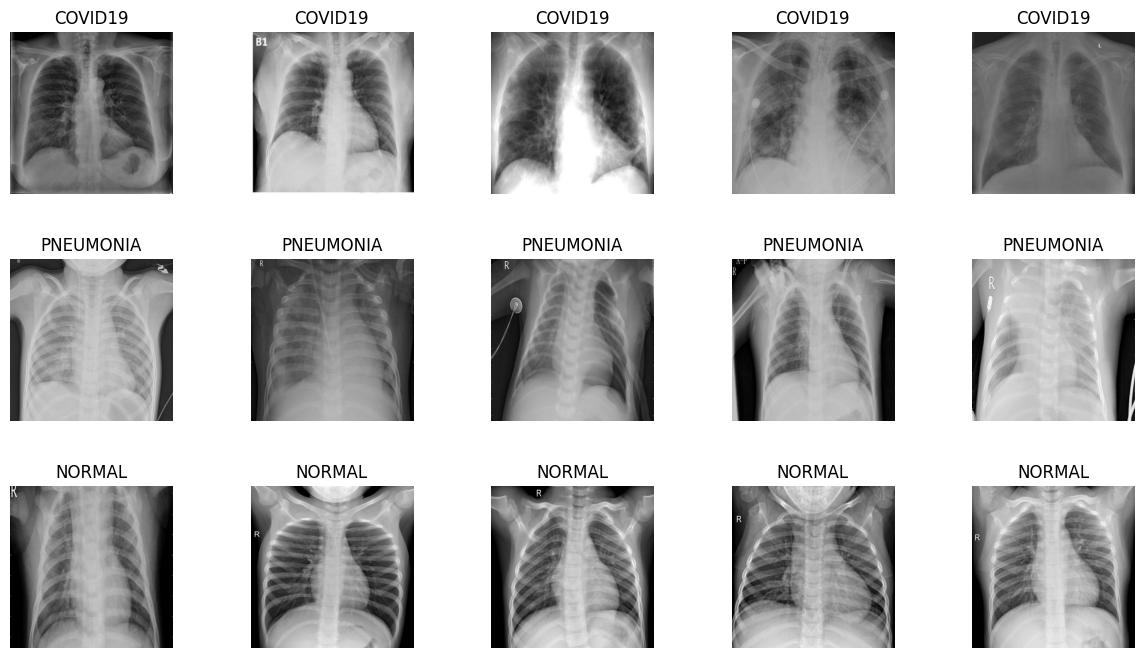

In [ ]:
# Classes available for the task
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = 3

# TODO: YOUR SOLUTION HERE
import random
num_samples =5
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

for i, class_dir in enumerate(train_class_dirs):
    class_name = os.path.basename(class_dir)
    class_images = glob(os.path.join(class_dir, "*"))

    # Randomly select num_samples images from the class
    samples = random.sample(class_images, num_samples)

    for j, sample_path in enumerate(samples):
        plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
        image = imageio.imread(sample_path)
        plt.imshow(image)
        plt.title(f"{class_name}")
        plt.axis('off')
plt.show()


You should see x-ray images from each class and their corresponding labels in their titles. To reflect on our understanding of the dataset, please answer the following **questions**:
- How many classes are provided in the datasets?
- Are the images balanced along all the classes in the respective data splits?

- 3
- yes

Let's set the directories for the respective datasets

In [ ]:
# Splits for the dataset

train_dir = os.path.join(data_folder, "train")
val_dir = os.path.join(data_folder, "val")
test_dir = os.path.join(data_folder, "test")
unknown_dir = os.path.join(data_folder, "unknown")

Now, we obtain the statistics (mean and standard deviation) from the training dataset to be used for normalizing the datasets

In [ ]:
# DO NOT CHANGE
train_images = []
for class_name in classes:
    train_images.extend(glob(os.path.join(train_dir, class_name, "*.jpg")))

to_tensor = torchvision.transforms.ToTensor()
imgs = torch.stack([to_tensor(imageio.imread(im)) for im in train_images])
print(imgs.shape)

# And then compute the mean and standard deviation independently for the image channels.
# (The channels are stored in dim=1, by excluding this below we achieve this.)
mean = torch.mean(imgs, dim=(0, 2, 3))
std = torch.std(imgs, dim=(0, 2, 3))

# Delete the images again in order to save memory.
del imgs

print(mean)
print(std)

torch.Size([450, 3, 512, 512])
tensor([0.4949, 0.4952, 0.4957])
tensor([0.2298, 0.2298, 0.2298])


In [ ]:
train_dataset_mean = mean
train_dataset_std = std

In [ ]:
train_dataset_mean

tensor([0.4949, 0.4952, 0.4957])

**Implement PyTorch dataloader**

As a next step, we implement a `torch.utils.data.Dataset` followed by the `torch.utils.data.DataLoader` to have access to our data during training, validation and testing. In our case, the data is stored in a format that is already compatible with `torchvision.datasets.ImageFolder`.

To use the image data in PyTorch it first needs to be transformed. You can use the transformations from [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) for this. Here, we need to:
- Convert the image data to a `torch.tensor` (`transforms.ToTensor`)
- Standardize the inputs based on their data statistics (`transforms.Normalize`)
- Resize the images (`transforms.Resize`). Note that resizing is not strictly necessary, but will speed up training and resize the images to a size that better matches the ImageNet pretraining data.

To combine several transforms together, you can use `torchvision.transforms.Compose` by passing the list of 'transform' objects to compose.

In [ ]:
# We resize the images to the size 256 x 256 to speed up training
height = width = 256

# Get the usual transforms to have the inputs from dataloaders as expected
def get_transforms(height, width):
    # TODO: YOUR CODE HERE
    transform =transforms.Compose([
        transforms.ToTensor(),  # Convert image to torch.tensor
        transforms.Normalize(mean=train_dataset_mean, std=train_dataset_std),  # Standardize inputs
        transforms.Resize((height, width))  # Resize the image
    ])
    return transform

In [ ]:
# Batch size
batch_size = 16  # TODO: YOUR CHOICE HERE

# Datasets
# TODO: YOUR SOLUTION HERE
train_dataset = torchvision.datasets.ImageFolder(train_dir,get_transforms(height, width))
val_dataset = torchvision.datasets.ImageFolder(val_dir,get_transforms(height, width))
test_dataset = torchvision.datasets.ImageFolder(test_dir,get_transforms(height, width))

# Dataloaders
# TODO: YOUR SOLUTION HERE
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size,True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size,True)

Now let's visualize the images after transformation as they are returned from the training loader.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


COVID19,  NORMAL,  COVID19,  NORMAL,  COVID19,  COVID19,  NORMAL,  COVID19,  COVID19,  COVID19,  NORMAL,  NORMAL,  NORMAL,  PNEUMONIA,  NORMAL,  COVID19, 


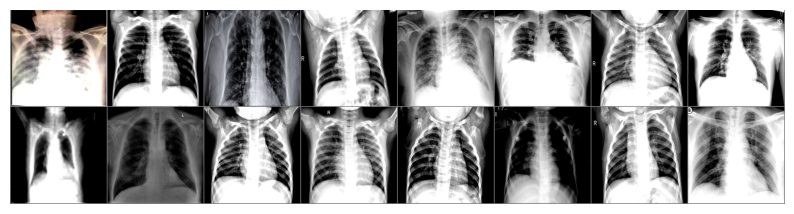

In [ ]:
# Function to show images
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain random training images
images, labels = next(iter(train_loader))

# Show the images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Architecture

We will use the ResNet implementation from torchvision, see https://pytorch.org/vision/stable/models.html, for this exercise.

- We start with the smallest ResNet model, the ResNet18 (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
- And will then use deeper ResNets to explore how well larger models can be trained on a small dataset.
- To use random weight initialization (in order to train from scratch), you can just create models without passing additional arguments like so: `torchvision.models.<MODEL_NAME>()`.

We need to adapt the model to fit with our purpose. For this, we must change the output dimension of the last fully-connected layer to consider the number of classes in our problem. Let's check the last layer out.

In [ ]:
# Let's get the resnet18 architecture and understanding the backbone (in order to adapt it to our problem)
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We see above that there is a component called `fc` that consists of a `Linear` layer. To make use of ResNet18 for our classification task, we need to change the `out_features` of the linear layer to the number of classes of our problem. In our case, it's `num_classes` (=3).

In [ ]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


To replace the last layer (classification layer) you can use the following code. (Here we provide a stand-alone code snippet)

```python
import torchvision
import torch.nn as nn

model = torchvision.models.resnet18()

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
model.to(device)
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dirc="/content/drive/MyDrive/DL"

In [ ]:
# Replacing the last layer(s) of ResNet18 to match our number of classes
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet18()
model.fc = nn.Linear(512, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet18_v4"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet18_v4-from-scratch.pt


If you now display the model (using `print(model)`) you should see that its last layer has been updated.

### Training

Let's train the model for 10 epochs, using the `Adam` optimizer, `CrossEntropyLoss` as the criterion (loss function) and a learning rate scheduler (e.g. `ReduceLROnPlateau`).

In [ ]:
# Clearing the GPU cache
torch.cuda.empty_cache()
print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loader, val_loader, model, 10, criterion, optimizer, scheduler, early_stopping, device)

Starting training from scratch with network:  resnet18_v4
450/450: [==============================>.] - ETA 0.2s
Epoch: 1
Training Loss: 0.937 , Training Accuracy:0.513 => Validation Loss: 1.302, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 0.951 , Training Accuracy:0.547 => Validation Loss: 0.819, Validation Accuracy: 0.727 
450/450: [==============================>.] - ETA 0.2s
Epoch: 3
Training Loss: 0.654 , Training Accuracy:0.780 => Validation Loss: 0.667, Validation Accuracy: 0.713 
450/450: [==============================>.] - ETA 0.2s
Epoch: 4
Training Loss: 0.494 , Training Accuracy:0.816 => Validation Loss: 0.554, Validation Accuracy: 0.760 
450/450: [==============================>.] - ETA 0.3s
Epoch: 5
Training Loss: 0.351 , Training Accuracy:0.862 => Validation Loss: 0.504, Validation Accuracy: 0.800 
450/450: [==============================>.] - ETA 0.2s
Epoch: 6
Training Loss: 0.281 , Training Accuracy:0.904 =

Now, let's see how the accuracy and loss plots look for our training.

0.8666666666666667


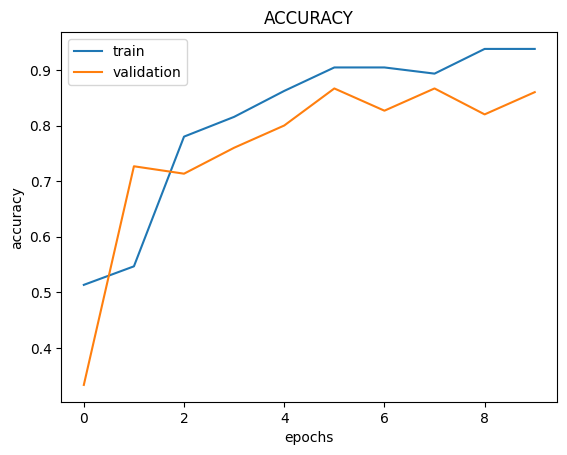

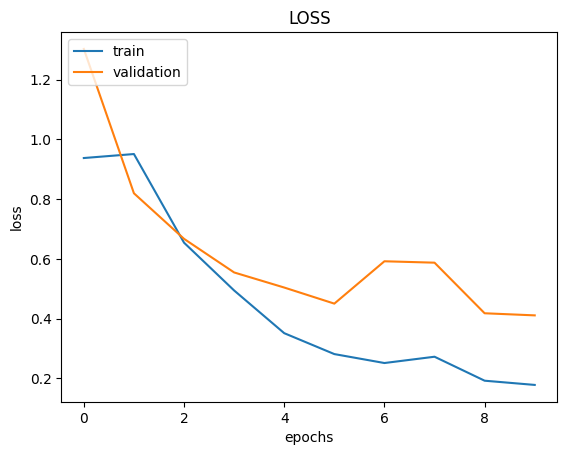

In [ ]:
# Training and validation accuracy plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(accuracy, val_accuracy,"accuracy")


# Training and validation loss plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

### Evaluation on the test set

Let's check the test accuracy and confusion matrix. All the required functionality is already provided in `ex3_utils.py` and you just need to read the corresponding functions to understand how to call them here.

In [ ]:
# Loading the best model for inference (NOTE: you should load the checkpoints to the expected model architecture, else you might get some mismatch errors)
# TODO: YOUR SOLUTION HERE

model = torchvision.models.resnet18()
model.fc = nn.Linear(512, 3)
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)


# Provide the testing dataset wrapped in a dataloader to check for inference
# TODO: YOUR SOLUTION HERE
correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

Accuracy of /content/drive/MyDrive/DL/covid-19-resnet18_v4-from-scratch.pt on the Test Images: 86 %


In [ ]:
# Get the confusion matrix for the test dataset
# TODO: YOUR SOLUTION HERE
cm = utils.get_confusion_matrix(classes, test_loader, model, device)


# See the precision, recall and accuracy per class for the test dataset
# TODO: YOUR SOLUTION HERE
utils.check_precision_recall_accuracy(cm,classes)

COVID19 - recall :  0.94666666  precision :  0.94666666  accuracy :  0.96444446
NORMAL - recall :  0.8051948  precision :  0.82666665  accuracy :  0.8755556
PNEUMONIA - recall :  0.8356164  precision :  0.81333333  accuracy :  0.8844444


0.8622222222222222


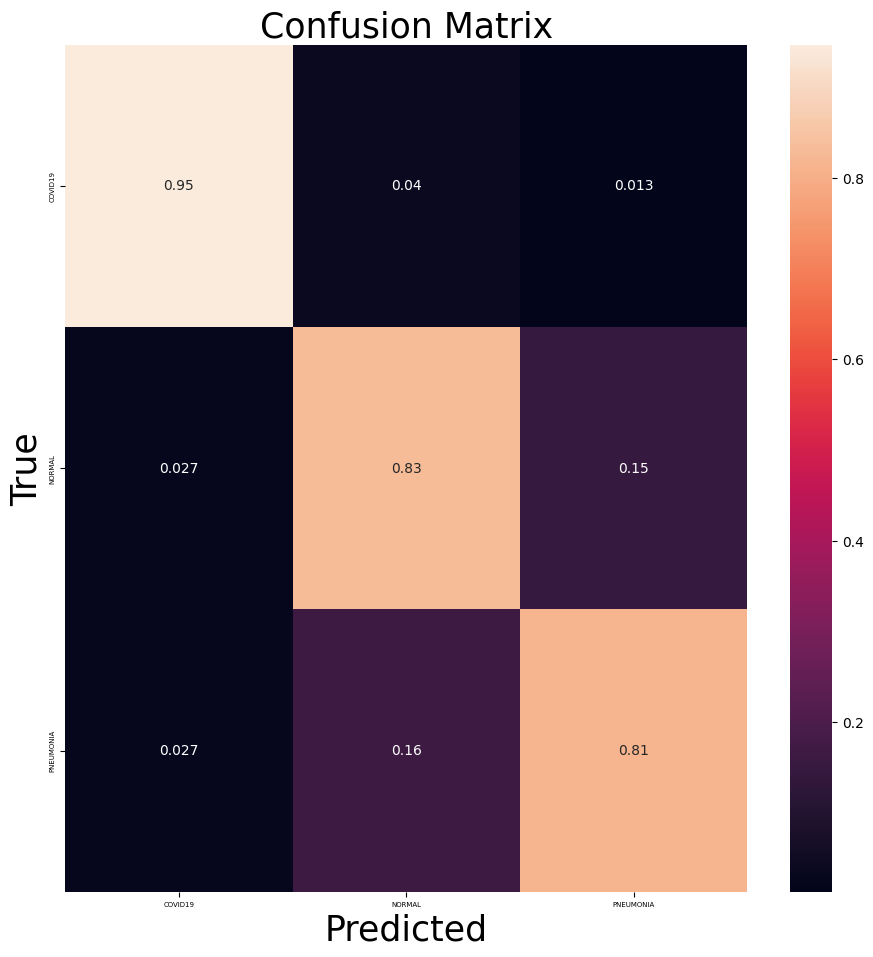

In [ ]:
# Check the confusion matrix heatmap to visually see the evaluation on the test set
# TODO: YOUR SOLUTION HERE
utils.visualize_confusion_matrix(cm, classes, correct, total)

Now let's try training deeper ResNet architectures using the same hyperparameters from above:
- Train and evaluate a ResNet34 from scratch.
- Train and evaluate a ResNet50 from scratch.

In [ ]:
# TODO: YOUR SOLUTIONS HERE


# HINT: (for the workflow)
#    - Start with training a ResNet34:
#          - Updating the last layers (training the network from scratch)
#          - REMEMBER: Save the respective checkpoints uniquely, and initialize the early stopping with them.
#          - Use the expected hyperparameters for training
#          - Observe the loss and accuracy curves for training and validation
#    - Next, train a ResNet50 (following the same suggestion as above)
#    - Finally, evaluate both the trained models from above on the test set and answer the questions.

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet34-from-scratch.pt
Starting training from scratch with network:  resnet34
450/450: [==============================>.] - ETA 0.2s
Epoch: 1
Training Loss: 1.070 , Training Accuracy:0.460 => Validation Loss: 1.374, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 1.022 , Training Accuracy:0.518 => Validation Loss: 0.828, Validation Accuracy: 0.700 
450/450: [==============================>.] - ETA 0.2s
Epoch: 3
Training Loss: 0.646 , Training Accuracy:0.767 => Validation Loss: 0.619, Validation Accuracy: 0.713 
450/450: [==============================>.] - ETA 0.3s
Epoch: 4
Training Loss: 0.494 , Training Accuracy:0.798 => Validation Loss: 0.604, Validation Accuracy: 0.787 
450/450: [==============================>.] - ETA 0.3s
Epoch: 5
Training Loss: 0.402 , Training Accuracy:0.836 => Validation Loss: 0.558, Validation Accuracy: 0.793 
450/450: [===

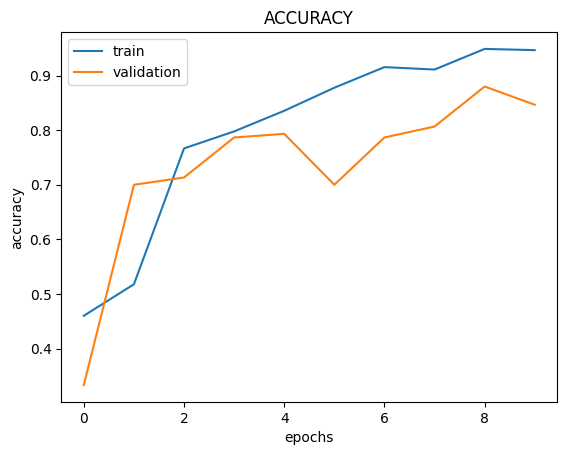

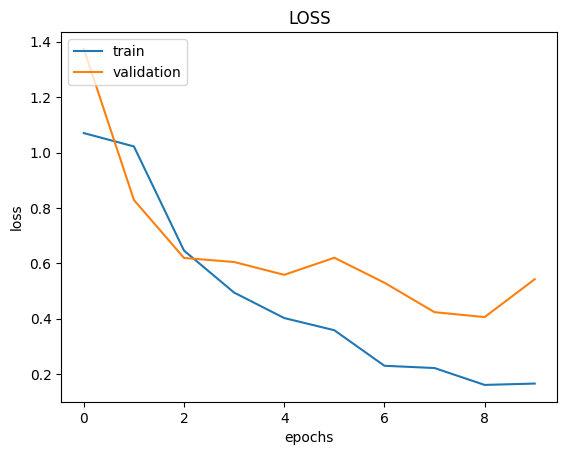

In [ ]:
model = torchvision.models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet34"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loader, val_loader, model, 10, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of /content/drive/MyDrive/DL/covid-19-resnet50-from-scratch.pt on the Test Images: 87 %
COVID19 - recall :  0.9358974  precision :  0.97333336  accuracy :  0.9688889
NORMAL - recall :  0.80487806  precision :  0.88  accuracy :  0.8888889
PNEUMONIA - recall :  0.8769231  precision :  0.76  accuracy :  0.8844444
0.8711111111111111


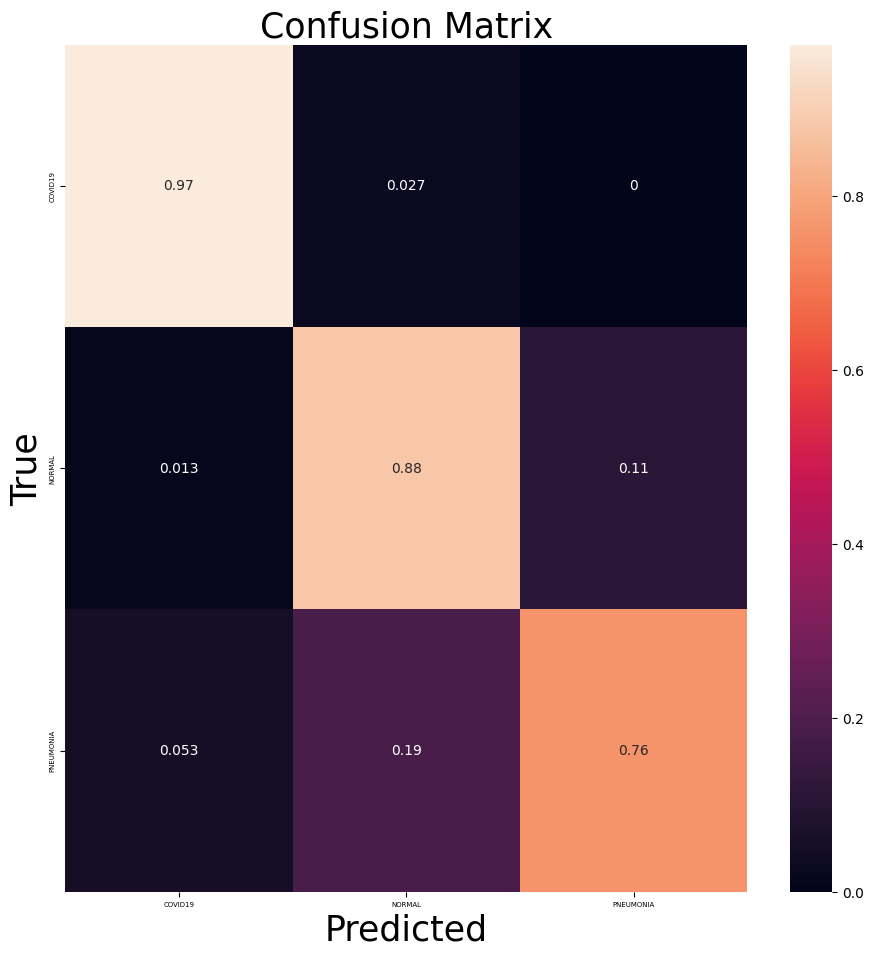

In [ ]:
model = torchvision.models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, "covid-19-resnet34-from-scratch.pt")))
model.to(device)


correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)



Model: ResNet34
>| Learning rate, batch size=200   | Loss/ Accuracy |
|:-------: |:-----------------------------:|
| 1e-3 | COVID19 - recall :  nan  precision :  0.0  accuracy :  0.6666667
|| NORMAL - recall :  0.33333334  precision :  1.0  accuracy :  0.33333334
||PNEUMONIA - recall :  nan  precision :  0.0  accuracy :  0.6666667
||num_epochs:  60  learning rate: 0.001 test_acc= 0.3333
||
| 5e-4| COVID19 - recall :  0.8674699  precision :  0.96  accuracy :  0.93777776
||NORMAL - recall :  0.6166667  precision :  0.49333334  accuracy :  0.72888887
||PNEUMONIA - recall :  0.58536583  precision :  0.64  accuracy :  0.72888887
||num_epochs:  60  learning rate: 0.0005 test_acc= 0.6978



The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-from-scratch.pt
Starting training from scratch with network:  resnet50
450/450: [==============================>.] - ETA 0.4s
Epoch: 1
Training Loss: 1.067 , Training Accuracy:0.424 => Validation Loss: 1.402, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.3s
Epoch: 2
Training Loss: 1.091 , Training Accuracy:0.387 => Validation Loss: 1.071, Validation Accuracy: 0.327 
450/450: [==============================>.] - ETA 0.3s
Epoch: 3
Training Loss: 1.039 , Training Accuracy:0.407 => Validation Loss: 1.004, Validation Accuracy: 0.553 
450/450: [==============================>.] - ETA 0.4s
Epoch: 4
Training Loss: 1.014 , Training Accuracy:0.493 => Validation Loss: 0.962, Validation Accuracy: 0.547 
450/450: [==============================>.] - ETA 0.4s
Epoch: 5
Training Loss: 0.927 , Training Accuracy:0.553 => Validation Loss: 0.948, Validation Accuracy: 0.553 
450/450: [===

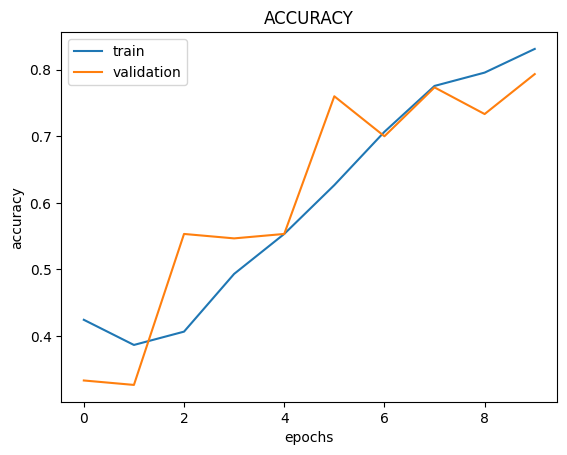

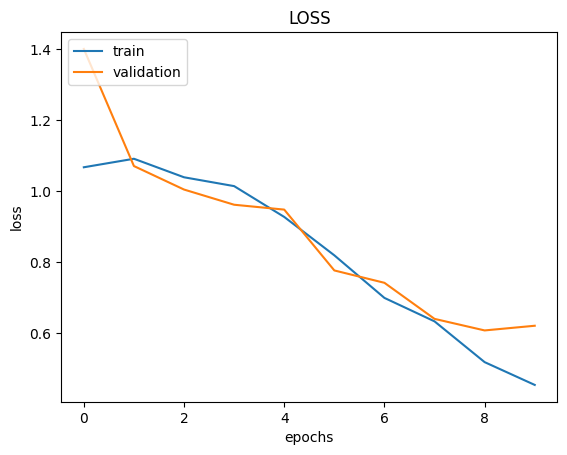

In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loader, val_loader, model, 10, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

Accuracy of /content/drive/MyDrive/DL/covid-19-resnet50-from-scratch.pt on the Test Images: 77 %
COVID19 - recall :  0.85897434  precision :  0.8933333  accuracy :  0.91555554
NORMAL - recall :  0.8030303  precision :  0.70666665  accuracy :  0.84444445
PNEUMONIA - recall :  0.67901236  precision :  0.73333335  accuracy :  0.79555553
0.7777777777777778


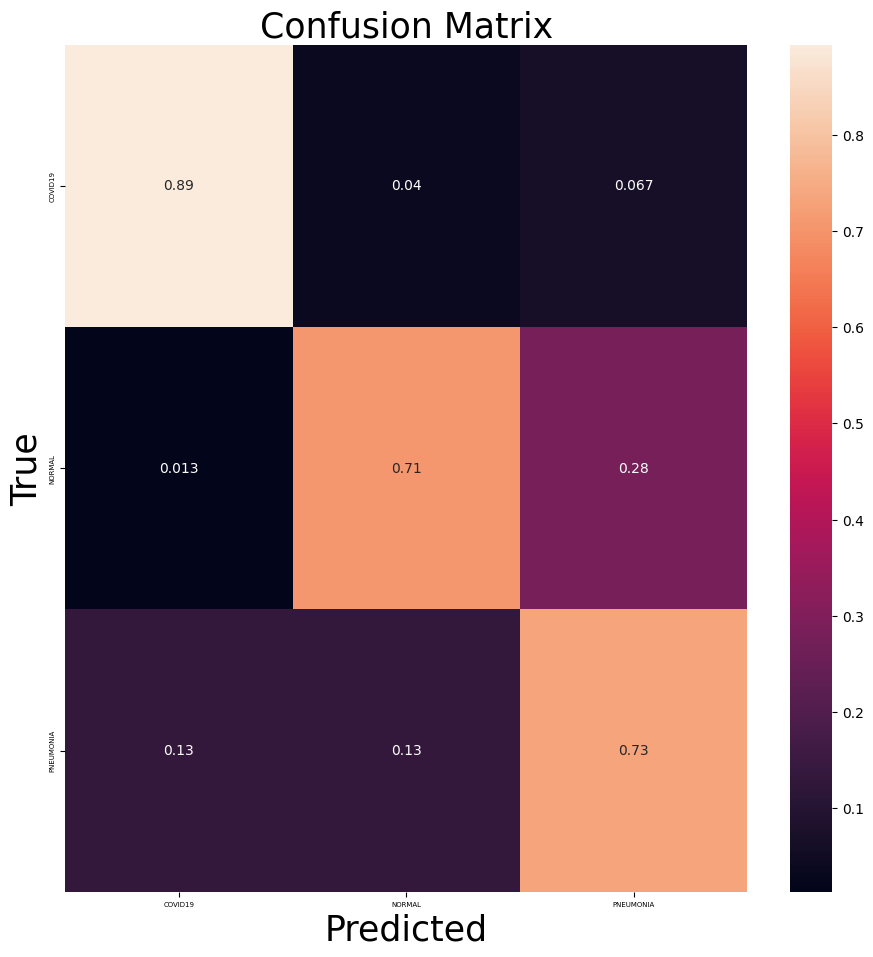

In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, "covid-19-resnet50-from-scratch.pt")))
model.to(device)


correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

Model: ResNet50 I
>| Learning rate, batch size=200   | Loss/ Accuracy |
|:-------: |:-----------------------------:|
| 1e-3 | COVID19 - recall :  0.85714287  precision :  0.8  accuracy :  0.8888889
||NORMAL - recall :  0.63106793  precision :  0.8666667  accuracy :  0.7866667
||PNEUMONIA - recall :  0.5576923  precision :  0.38666666  accuracy :  0.6933333
||num_epochs:  60  learning rate: 0.001 test_acc= 0.6844
||
|5e-4| COVID19 - recall :  0.75789475  precision :  0.96  accuracy :  0.8844444
||NORMAL - recall :  0.6931818  precision :  0.81333333  accuracy :  0.81777775
||PNEUMONIA - recall :  0.6904762  precision :  0.38666666  accuracy :  0.73777777
||num_epochs:  60  learning rate: 0.0005 test_acc= 0.72

**Questions**:

1. How does the performance of the three architectures compare to each other? Are there any specific patterns you can see in the confusion matrices?
2. Is there a correlation between the dataset size and depth of the network?
3. Given these observations, which model would you prefer for training on a small dataset from scratch?

1. Resnet50 performs better than Resnet34 and this model performs better than the Resnet18. The confucsion matrix becomes less correlated and the precision of each class becomes more evenly distributed as we train more parameters.
2. The deeped our model is the better higher-order features can be learned. Large datasizes faciliate this task. For small dataset the output might vary and it might be better to use less deep network to avoid overfitting. This is consistent with some studies such as https://doi.org/10.1016/j.ecoinf.2020.101137 suggesting that "There was no clear or consistent benefit of using deep neural networks with smaller sample sizes (100 and 1000 sites)."
3. Probably Resnet34

#### Now let's try with Data Augmentation

A common strategy when dealing with small datasets is to add data augmentations.

Let's try a few augmentations from [torchvision.transforms](https://pytorch.org/vision/main/transforms.html) that do not significantly distort the data (stay on the data manifold) and train a ResNet50. Here, we want to see if augmentations allow us to train deeper CNNs.
Common augmentations for data augmentation are:
- flipping the inputs along the axes.
- changing the brightness, contrast and saturation of the inputs.
- adding small noise to the input.

You can try different combinations of augmentations here. You can add augmentations by updating the `transform` passed to the train dataset. You can again use `Compose` to chain augmentations.

Note; you should only introduce augmentation for the training and validation datasets, **not** for the test dataset. Otherwise the evaluation between models is not consistent anymore.

In [ ]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (incorporating data augmentation strategies)
#    = (the training workflows are the same as above)

We need to apply the new transforms to the dataset and then use our dataloader. Let's reuse our scripts from above, now with the added data augmentation strategies.

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def get_transforms_aug(height, width):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
        torchvision.transforms.GaussianBlur(kernel_size = (7,13), sigma=(0.1,.2)),
        AddGaussianNoise(0,1), #check that whther with mean=0 and std=1 works better
        torchvision.transforms.Resize((height, width)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean_imagenet, std_imagenet),
        ])
    return transform

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

def get_DataLoader(transformer,batch_size = 16 ):
    train_dataset = torchvision.datasets.ImageFolder(train_dir,transformer)
    val_dataset = torchvision.datasets.ImageFolder(val_dir,transformer)

    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,True)
    val_loader = torch.utils.data.DataLoader(val_dataset,batch_size,True)
    return train_loader,val_loader

transform_flip =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(mean=train_dataset_mean, std=train_dataset_std),
        transforms.Resize((256, 256))
    ])
train_loaderf,val_loaderf=get_DataLoader(transform_flip)

transform_brightness =transforms.Compose([
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.25),
        transforms.Normalize(mean=train_dataset_mean, std=train_dataset_std),
        transforms.Resize((256, 256))
    ])
train_loaderb,val_loaderb=get_DataLoader(transform_brightness)

transform_noise =transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=train_dataset_mean, std=train_dataset_std),
        AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
train_loadern,val_loadern=get_DataLoader(transform_noise)

transform_all =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=train_dataset_mean, std=train_dataset_std),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
train_loadera,val_loadera=get_DataLoader(transform_all)




In [ ]:
train_dataset_aug = torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=get_transforms(height, width))
val_dataset_aug = torchvision.datasets.ImageFolder(root=val_dir,
                                               transform=get_transforms(height, width))


train_dataset_both = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])
val_dataset_both = torch.utils.data.ConcatDataset([val_dataset, val_dataset_aug])

# Dataloaders
# TODO: YOUR SOLUTION HERE
train_loader_both = torch.utils.data.DataLoader(train_dataset_both, batch_size=batch_size, shuffle=True)
val_loader_both = torch.utils.data.DataLoader(val_dataset_both, batch_size=batch_size, shuffle=True)

Now, we are ready to train the ResNet50 with data augmentations. Let's train for longer (30 epochs) here, with the same hyperparameters as before, and evaluate the model on the test set.

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-flip-from-scratch.pt
Starting training from scratch with network:  resnet50-flip
450/450: [==============================>.] - ETA 0.4s
Epoch: 1
Training Loss: 1.017 , Training Accuracy:0.513 => Validation Loss: 1.416, Validation Accuracy: 0.373 
450/450: [==============================>.] - ETA 0.4s
Epoch: 2
Training Loss: 1.143 , Training Accuracy:0.347 => Validation Loss: 1.054, Validation Accuracy: 0.567 
450/450: [==============================>.] - ETA 0.4s
Epoch: 3
Training Loss: 1.059 , Training Accuracy:0.400 => Validation Loss: 1.018, Validation Accuracy: 0.533 
450/450: [==============================>.] - ETA 0.3s
Epoch: 4
Training Loss: 0.964 , Training Accuracy:0.656 => Validation Loss: 0.907, Validation Accuracy: 0.727 
450/450: [==============================>.] - ETA 0.4s
Epoch: 5
Training Loss: 0.845 , Training Accuracy:0.680 => Validation Loss: 0.797, Validation Accuracy: 0.680 
450

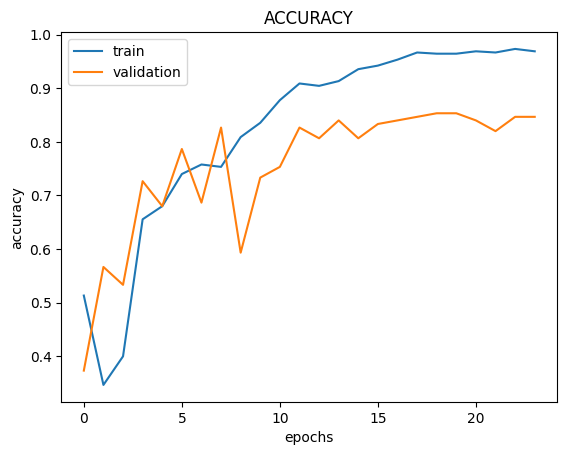

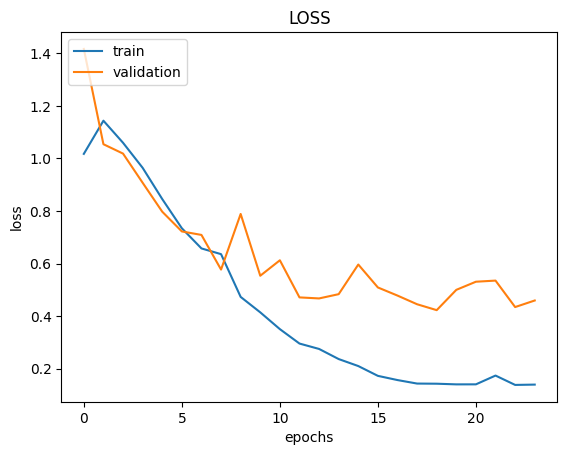

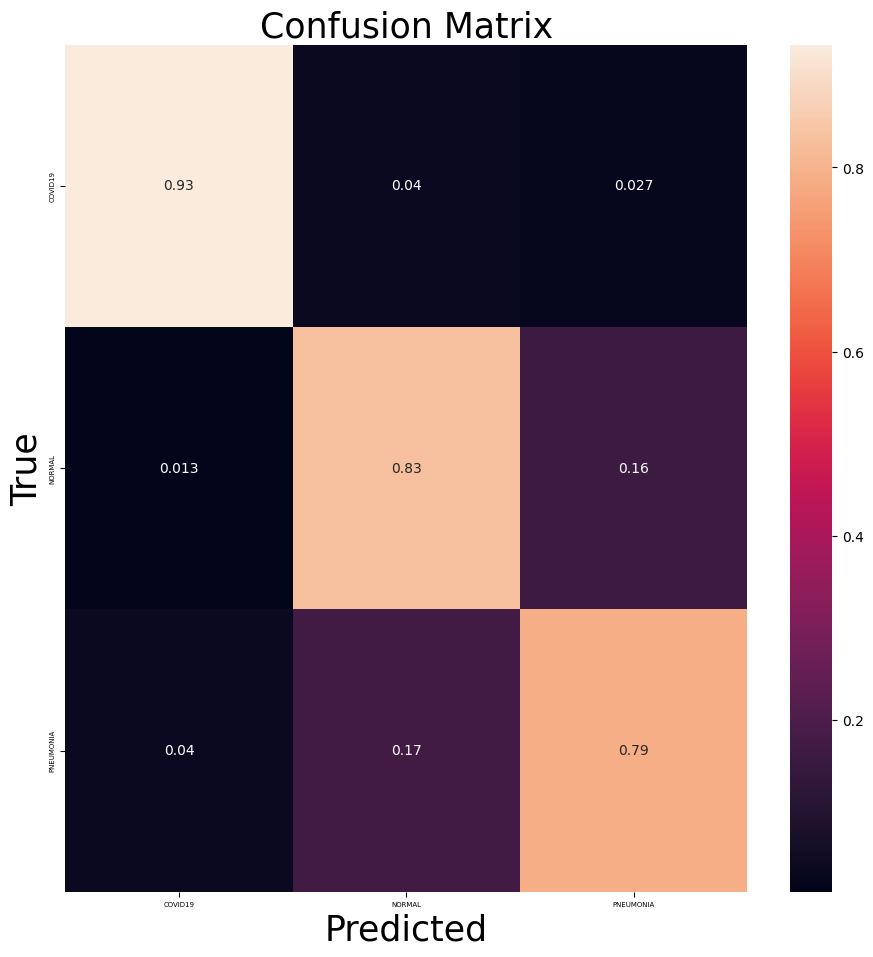

In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_featyures, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50-flip"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderf, val_loaderf, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))



model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-brightness-from-scratch.pt
Starting training from scratch with network:  resnet50-brightness
450/450: [==============================>.] - ETA 0.4s
Epoch: 1
Training Loss: 1.058 , Training Accuracy:0.429 => Validation Loss: 1.288, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.4s
Epoch: 2
Training Loss: 1.106 , Training Accuracy:0.376 => Validation Loss: 1.064, Validation Accuracy: 0.433 
450/450: [==============================>.] - ETA 0.5s
Epoch: 3
Training Loss: 1.036 , Training Accuracy:0.464 => Validation Loss: 1.003, Validation Accuracy: 0.673 
450/450: [==============================>.] - ETA 0.4s
Epoch: 4
Training Loss: 0.999 , Training Accuracy:0.496 => Validation Loss: 0.940, Validation Accuracy: 0.533 
450/450: [==============================>.] - ETA 0.4s
Epoch: 5
Training Loss: 0.858 , Training Accuracy:0.609 => Validation Loss: 0.873, Validation Accuracy

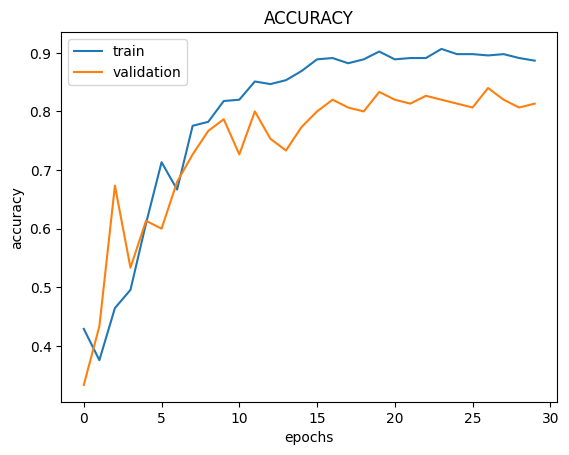

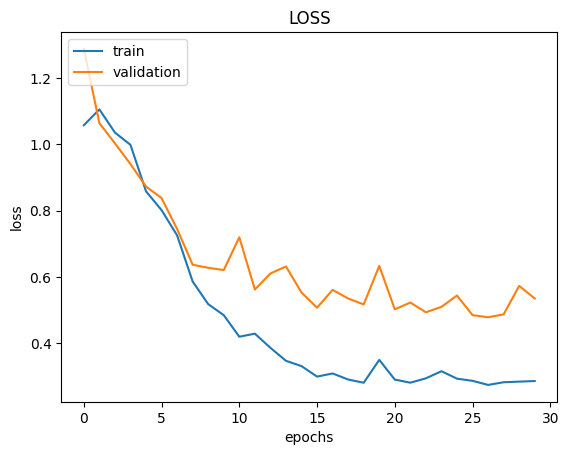

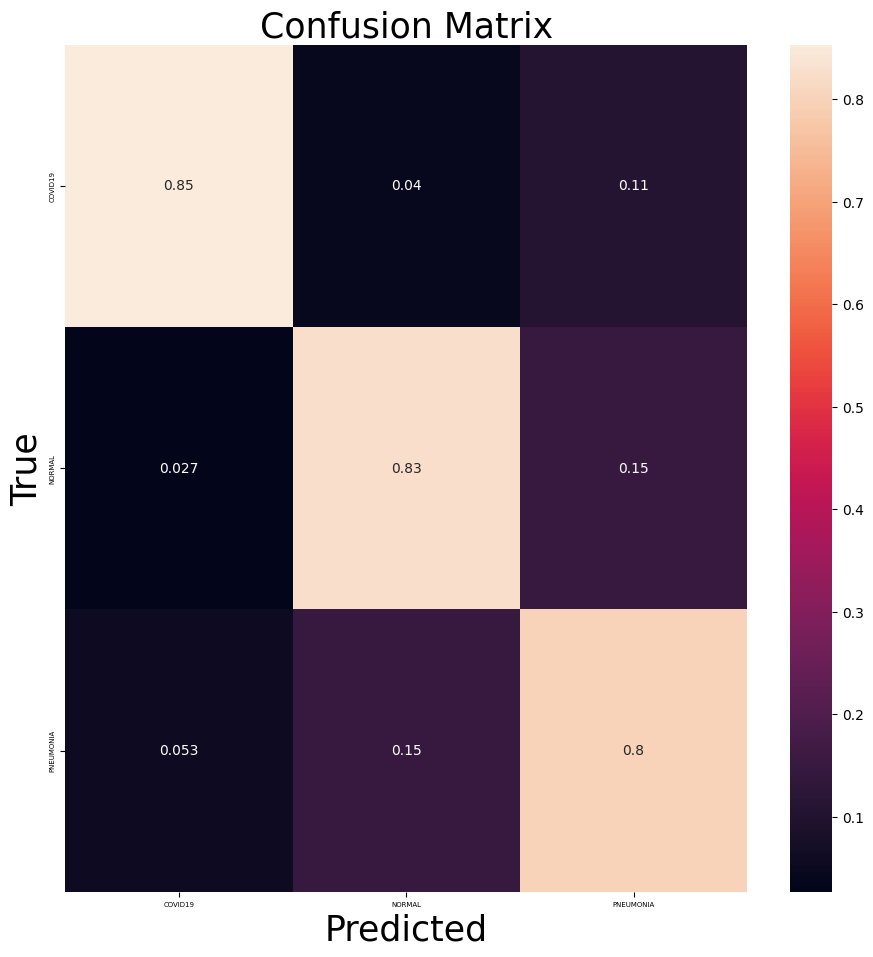

In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50-brightness"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderb, val_loaderb, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-noise-from-scratch.pt
Starting training from scratch with network:  resnet50-noise


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [==============================>.] - ETA 0.5s
Epoch: 1
Training Loss: 1.096 , Training Accuracy:0.389 => Validation Loss: 1.159, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.5s
Epoch: 2
Training Loss: 1.128 , Training Accuracy:0.344 => Validation Loss: 1.089, Validation Accuracy: 0.327 
450/450: [==============================>.] - ETA 0.5s
Epoch: 3
Training Loss: 1.099 , Training Accuracy:0.360 => Validation Loss: 1.081, Validation Accuracy: 0.407 
450/450: [==============================>.] - ETA 0.5s
Epoch: 4
Training Loss: 1.094 , Training Accuracy:0.382 => Validation Loss: 1.078, Validation Accuracy: 0.487 
450/450: [==============================>.] - ETA 0.5s
Epoch: 5
Training Loss: 1.080 , Training Accuracy:0.436 => Validation Loss: 1.067, Validation Accuracy: 0.473 
450/450: [==============================>.] - ETA 0.4s
Epoch: 6
Training Loss: 1.078 , Training Accuracy:0.382 => Validation Loss: 1.054, Validation Accuracy: 0.400 
450/

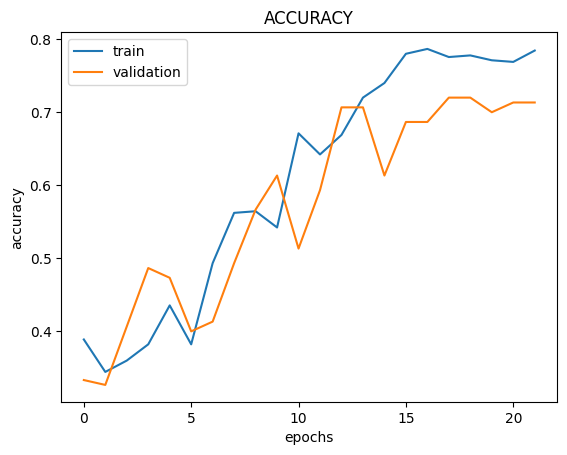

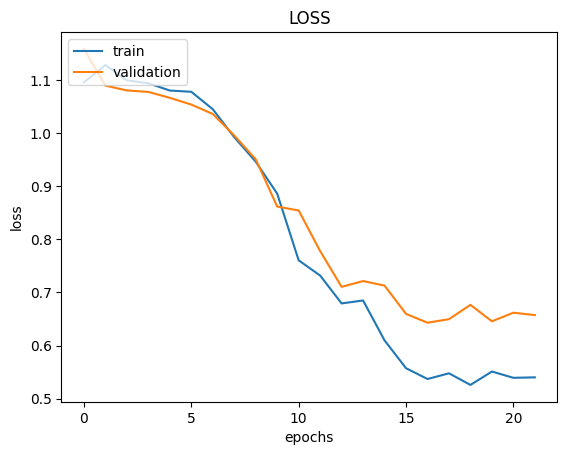

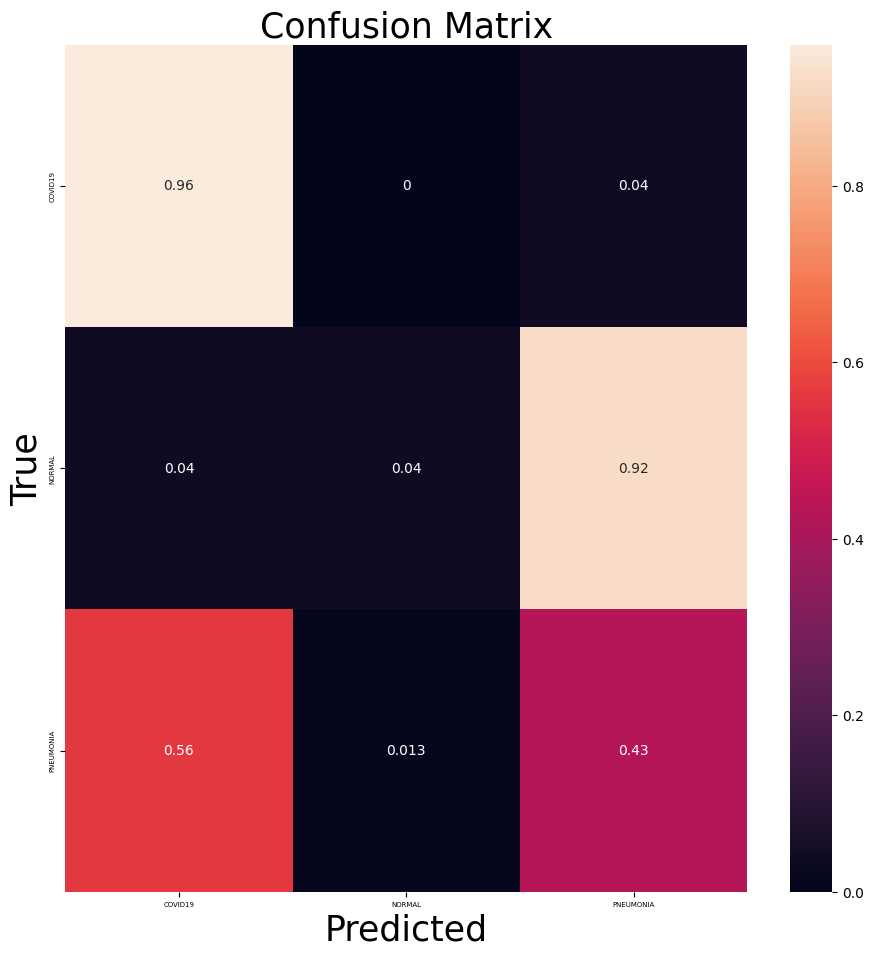

In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50-noise"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loadern, val_loadern, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-all-from-scratch.pt
Starting training from scratch with network:  resnet50-all
450/450: [==============================>.] - ETA 0.4s
Epoch: 1
Training Loss: 0.917 , Training Accuracy:0.573 => Validation Loss: 3.277, Validation Accuracy: 0.333 
450/450: [==============================>.] - ETA 0.4s
Epoch: 2
Training Loss: 1.213 , Training Accuracy:0.429 => Validation Loss: 1.044, Validation Accuracy: 0.527 
450/450: [==============================>.] - ETA 0.5s
Epoch: 3
Training Loss: 0.929 , Training Accuracy:0.547 => Validation Loss: 0.717, Validation Accuracy: 0.747 
450/450: [==============================>.] - ETA 0.4s
Epoch: 4
Training Loss: 0.726 , Training Accuracy:0.644 => Validation Loss: 0.745, Validation Accuracy: 0.660 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.4s
Epoch: 5
Training Loss: 0.644 , Training Accuracy:0.727 => Validation Loss: 0.809,

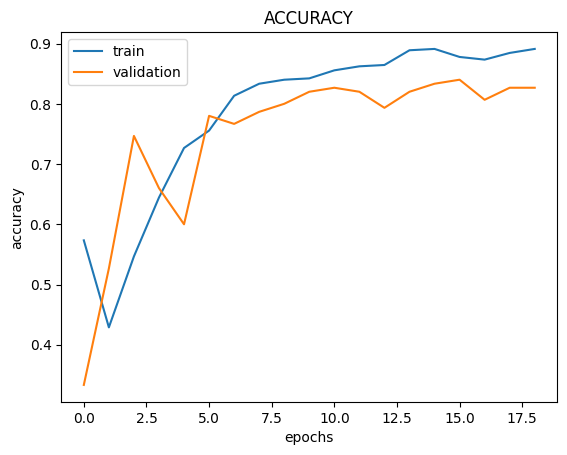

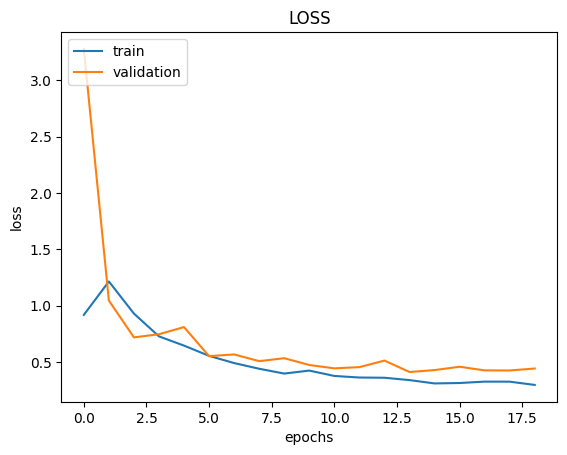

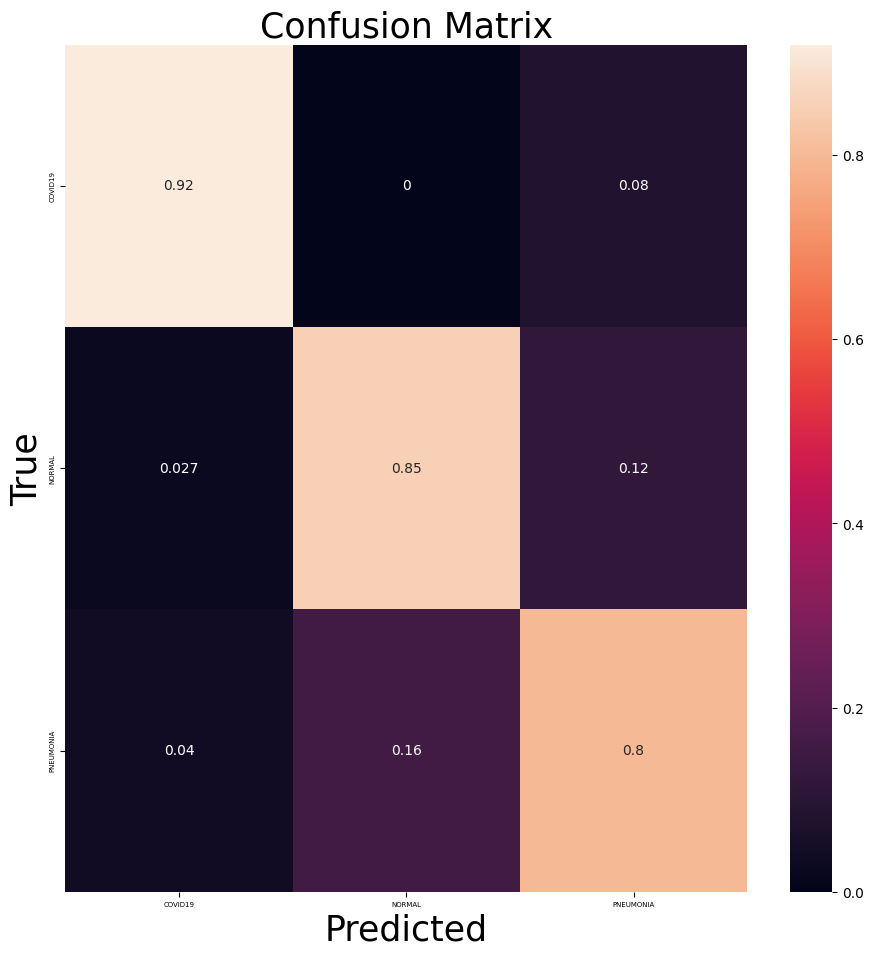

In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50-all-v2"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loadera, val_loadera, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

num_epochs:  30  learning rate: 0.0005
 16/900: [>...............................] - ETA 0.0s

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


900/900: [===============================>] - ETA 7.2s
Epoch: 1
Training Loss: 0.682 , Training Accuracy:0.711 => Validation Loss: 0.744, Validation Accuracy: 0.747 
900/900: [===============================>] - ETA 0.4s
Epoch: 2
Training Loss: 0.925 , Training Accuracy:0.609 => Validation Loss: 0.771, Validation Accuracy: 0.587 
EarlyStopping Counter: 1 out of 7
900/900: [===============================>] - ETA 0.3s
Epoch: 3
Training Loss: 0.709 , Training Accuracy:0.649 => Validation Loss: 0.758, Validation Accuracy: 0.707 
EarlyStopping Counter: 2 out of 7
900/900: [===============================>] - ETA 0.3s
Epoch: 4
Training Loss: 0.521 , Training Accuracy:0.788 => Validation Loss: 0.587, Validation Accuracy: 0.753 
900/900: [===============================>] - ETA 0.4s
Epoch: 5
Training Loss: 0.463 , Training Accuracy:0.811 => Validation Loss: 0.557, Validation Accuracy: 0.740 
900/900: [===============================>] - ETA 0.3s
Epoch: 6
Training Loss: 0.467 , Training Accura

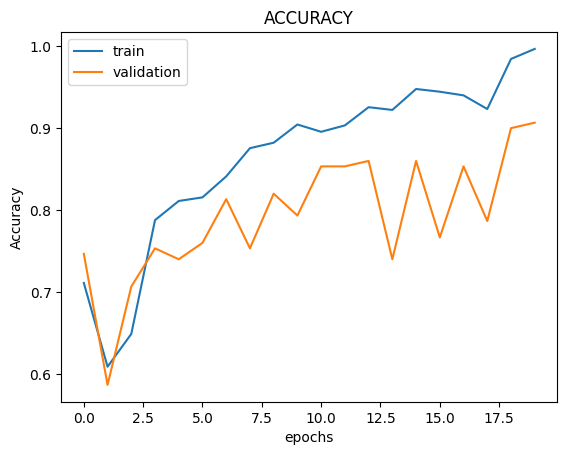

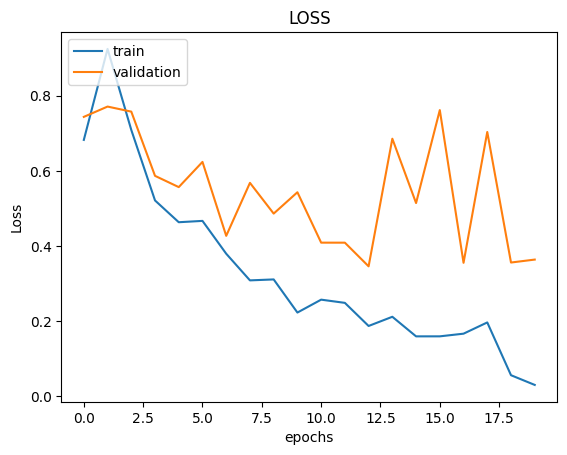

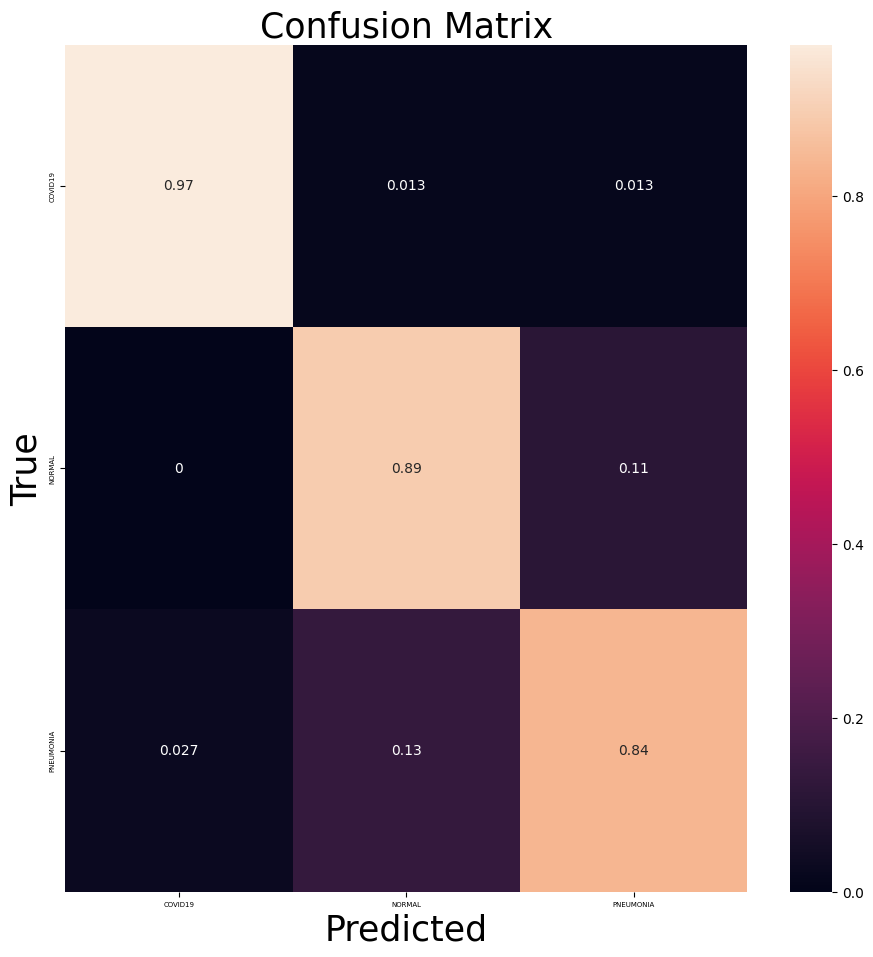

In [ ]:
import itertools
torch.cuda.empty_cache()


# model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, num_classes)
model.to(device)
# summary(model, input_size=(3, height, width))

for num_epochs, lr in itertools.product([30],[5e-4]):
    print("num_epochs: ",num_epochs, " learning rate:", lr)
    # Optimizer and loss configurations
    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = optim.Adam(model.parameters(),lr=lr)  # optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True)  # learning rate scheduler


    # Initializing the early stopping of the training
    checkpoint_path = root_dir+"ResNet50_aug.pt"
    early_stopping = utils.EarlyStopping(checkpoint_path=checkpoint_path, patience=7, verbose=False, delta=0)


    # HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
    train_accuracy_both, val_accuracy_both, train_losses_both, val_losses_both = utils.run_training(train_loader_both, val_loader_both, model,
                                                                                num_epochs, criterion,
                                                                    optimizer, scheduler=scheduler,
                                                                    early_stopping=early_stopping, device=device)

    utils.get_metric_plots(train_accuracy_both, val_accuracy_both, metric_name="Accuracy")
    utils.get_metric_plots(train_losses_both, val_losses_both, metric_name="Loss")

    # Provide the testing dataset wrapped in a dataloader to check for inference
    model2 = torchvision.models.resnet50()
    model2.fc = nn.Linear(2048, num_classes)
    model2.to(device)
    model2.load_state_dict(torch.load(checkpoint_path))
    correct, total = utils.test_evaluation(model2, test_loader, device)
    cm = utils.get_confusion_matrix(classes, test_loader, model2, device, view_cm=True)
    utils.check_precision_recall_accuracy(cm, classes)
    print("num_epochs: ",num_epochs, " learning rate:", lr, "test_acc=", round((correct / total),2) )
    utils.visualize_confusion_matrix(cm, classes, correct, total)
    print("------------------------")

**Questions**:

1. Does the effect of data augmentation match your expectation?
2. Are there other kinds of data augmentation that would make sense for this dataset? Think about augmentations that "leave the data manifold".

1. Adding data augmentation improves the performance of our model as it increases the size and variety of the dataset. Since our classification task seems to be very sensitive to noise, it was clear that it would probably worsen the performance. Chanching the brightness helps the model to learn to deal with a bad image quality. With the flip we can double our data, which is nice.
2. Cropping, rotating and splitting the dataset might also be considered as another options.

## ImageNet

The [ImageNet project](https://www.image-net.org/) provides a large-scale dataset with natural images. There exist different version of this dataset, the largest using 14 million annotated images for image classification with over 20,000 categories.

This dataset has been used by the ImageNet Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/#:~:text=The%20ImageNet%20Large%20Scale%20Visual,image%20classification%20at%20large%20scale.)) to benchmark classification algorithms competing to improve classification. The version fo the dataset used for this classification contains a million training images with 1,000 categeories (and corresponds to the version fo the dataset we discussed in the lecture).

`torchvision.models` has a pool of neural networks, for which pretrained ImageNet weights are also available. To make use of pretrained models, we need to preprocess the images based on the mean and standard deviation of ImageNet (this step is critical!). The statistics for ImageNet are provided [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#:~:text=1.0%5D%20and%20then-,normalized%20using%20mean%3D%5B0.485%2C%200.456%2C%200.406%5D%20and%20std%3D%5B0.229%2C%200.224%2C%200.225%5D.,-Next)

### ImageNet transfer learning for ResNet50

We will now check if transfer learning from ImageNet leads to improvements for our dataset. Here, we will focus on the ResNet50 as we have seen before that without transfer learning its performance is worse compared to smaller architectures for our dataset.

There are two different approaches for how we can fine-tune a CNN initialized with pretrained weights:
1. Update the weights for all layers of the network. For this approach we initialize with pretrained weights but otherwise train the network as before. See this code snippet:
   
    ```python
    import torchvision
    import torch.nn as nn

    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    # Let's replace the "fully connected" layer to match our expected output classes
    model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
    model.to(device)

    # Train the network as usual
    ```

2. Only update the weights of the last layer (classification layer). In this case we would "freeze" the pretrained network and use it as a fixed feature extractor. This is achieved by disabling parameter updates for all but the last layer of the network.

We will start with the first approach (fine-tuning the full network).

In [ ]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating all the layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)

In [ ]:
mean_imagenet=[0.485, 0.456, 0.406]
std_imagenet=[0.229, 0.224, 0.225]

transform_IN =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
train_loaderIN,val_loaderIN=get_DataLoader(transform_IN)

transformIN_t =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
test_datasetIN = torchvision.datasets.ImageFolder(test_dir,transformIN_t)
test_loaderIN = torch.utils.data.DataLoader(test_datasetIN,batch_size,True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.9MB/s]


The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-from-ImageNet.pt
Starting training from scratch with network:  resnet50
450/450: [==============================>.] - ETA 0.3s
Epoch: 1
Training Loss: 1.078 , Training Accuracy:0.467 => Validation Loss: 1.067, Validation Accuracy: 0.507 
450/450: [==============================>.] - ETA 0.4s
Epoch: 2
Training Loss: 0.926 , Training Accuracy:0.731 => Validation Loss: 0.693, Validation Accuracy: 0.913 
450/450: [==============================>.] - ETA 0.3s
Epoch: 3
Training Loss: 0.387 , Training Accuracy:0.936 => Validation Loss: 0.226, Validation Accuracy: 0.927 
450/450: [==============================>.] - ETA 0.4s
Epoch: 4
Training Loss: 0.145 , Training Accuracy:0.942 => Validation Loss: 0.329, Validation Accuracy: 0.860 
EarlyStopping Counter: 1 out of 5
450/450: [==============================>.] - ETA 0.3s
Epoch: 5
Training Loss: 0.071 , Training Accuracy:0.980 => Validation Loss: 0.165, Valida

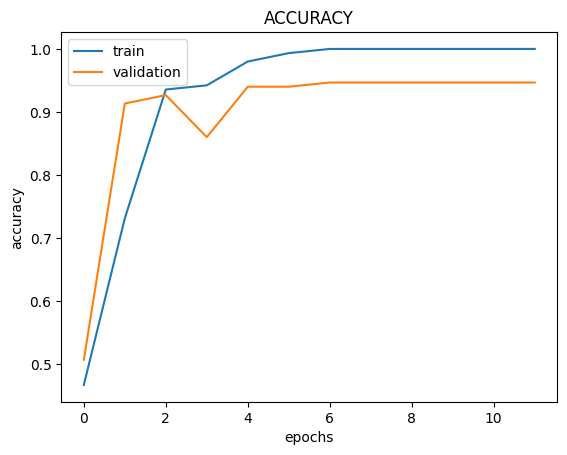

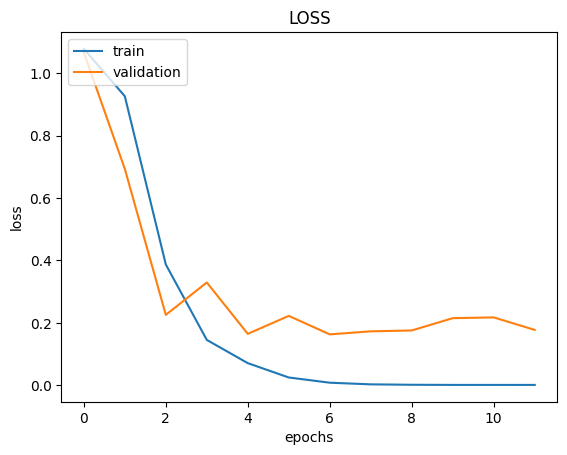

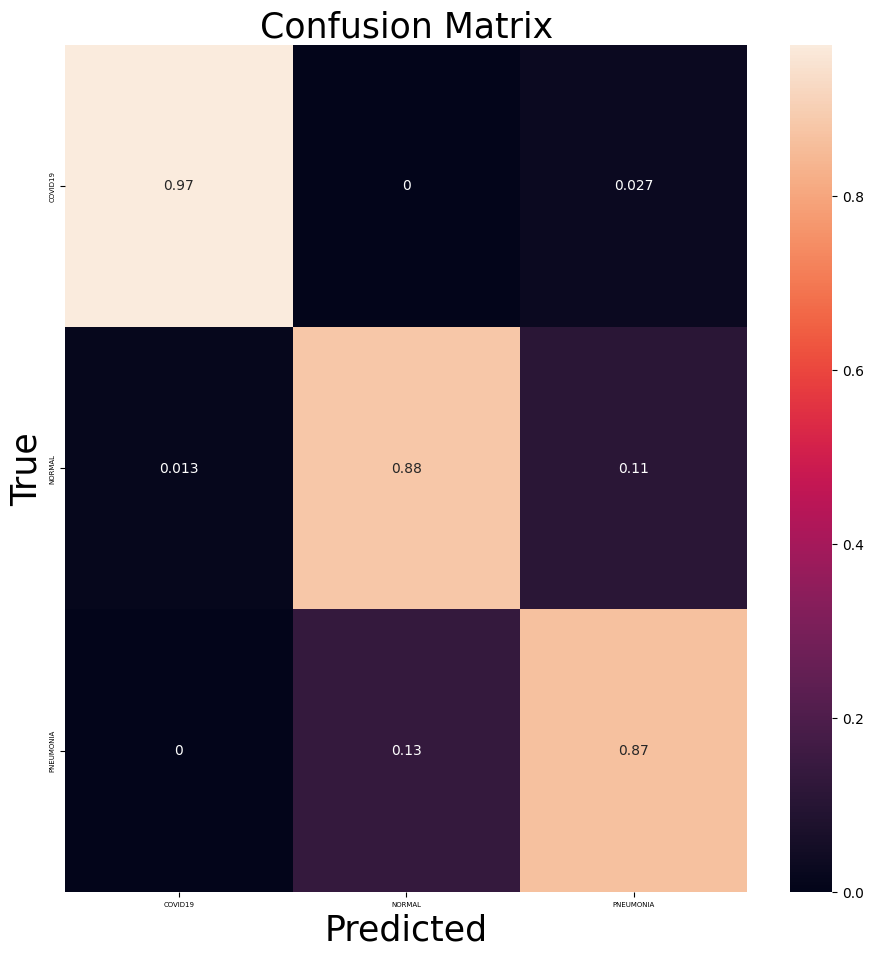

In [ ]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderIN, val_loaderIN, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))



model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

num_epochs:  160  learning rate: 0.0005
900/900: [===============================>] - ETA 0.6s
Epoch: 1
Training Loss: 0.800 , Training Accuracy:0.596 => Validation Loss: 0.673, Validation Accuracy: 0.667 
900/900: [===============================>] - ETA 0.4s
Epoch: 2
Training Loss: 1.102 , Training Accuracy:0.337 => Validation Loss: 1.066, Validation Accuracy: 0.440 
EarlyStopping Counter: 1 out of 17
900/900: [===============================>] - ETA 0.5s
Epoch: 3
Training Loss: 1.039 , Training Accuracy:0.424 => Validation Loss: 1.013, Validation Accuracy: 0.450 
EarlyStopping Counter: 2 out of 17
900/900: [===============================>] - ETA 0.6s
Epoch: 4
Training Loss: 0.979 , Training Accuracy:0.467 => Validation Loss: 0.951, Validation Accuracy: 0.470 
EarlyStopping Counter: 3 out of 17
900/900: [===============================>] - ETA 0.7s
Epoch: 5
Training Loss: 0.876 , Training Accuracy:0.527 => Validation Loss: 0.980, Validation Accuracy: 0.423 
EarlyStopping Counter: 4 

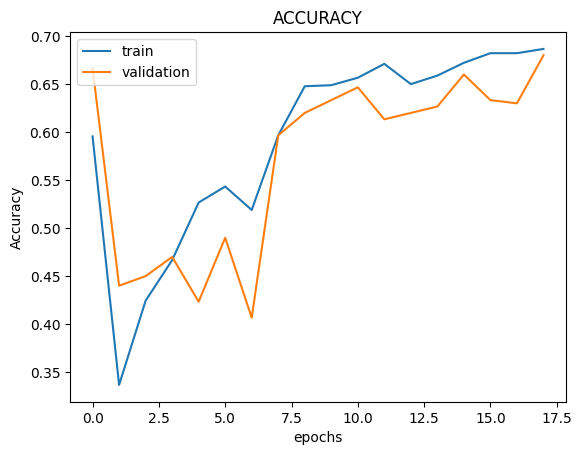

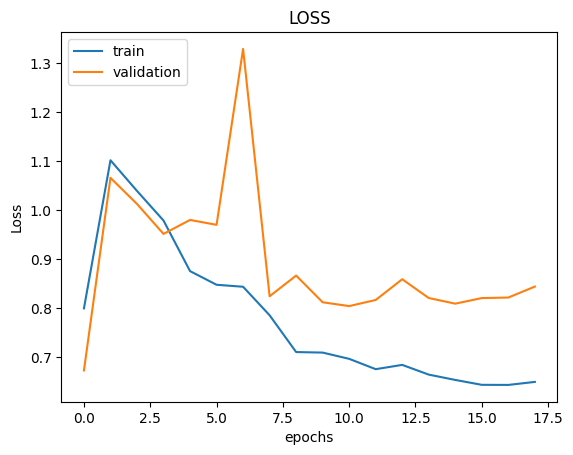

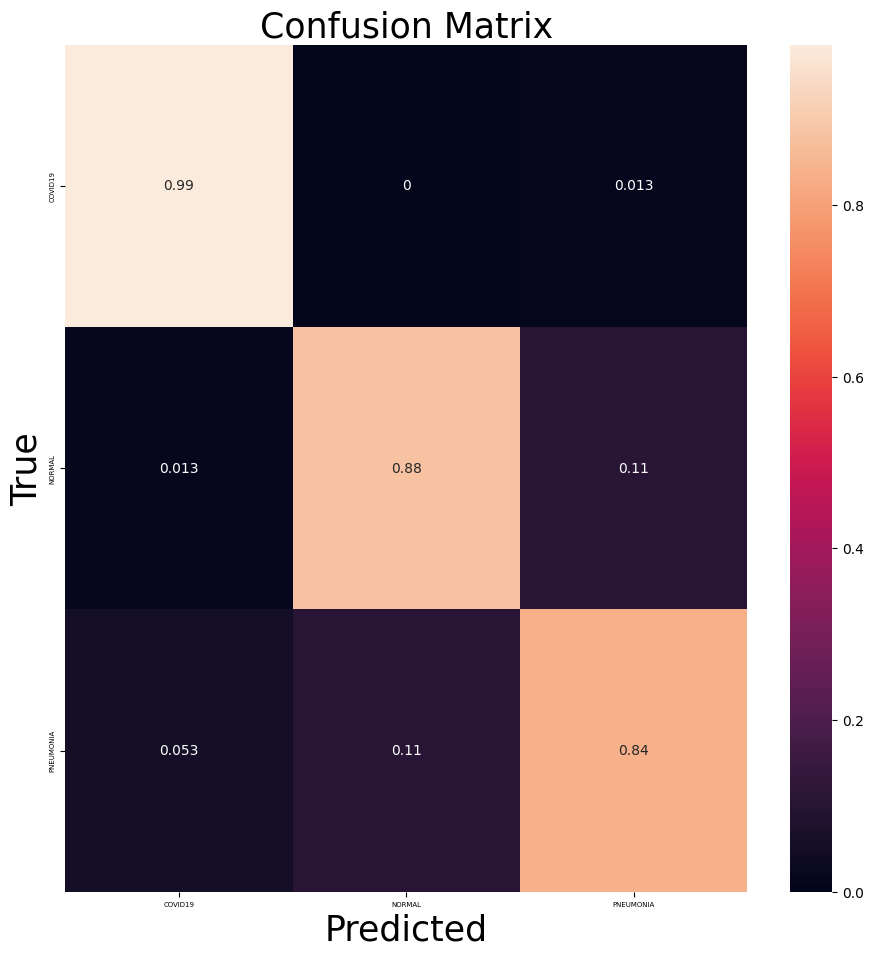

In [ ]:
# All layers

# HINT:
#    - Training a ResNet50 (updating all the layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)


model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(2048, num_classes)
model.to(device)


def get_transforms(height, width):
    # TODO: YOUR CODE HERE
    transform = normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((height, width)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean_imagenet, std_imagenet),
    ])
    return transform

def get_transforms_aug(height, width):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
        torchvision.transforms.GaussianBlur(kernel_size = (7,13), sigma=(0.1,.2)),
        torchvision.transforms.ToTensor(),
        AddGaussianNoise(0,1), #check that whther with mean=0 and std=1 works better
        torchvision.transforms.Resize((height, width)),
        torchvision.transforms.Normalize(mean_imagenet, std_imagenet),
        ])
    return transform


    #Dataset
train_dataset_aug = torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=get_transforms_aug(height, width))
val_dataset_aug = torchvision.datasets.ImageFolder(root=val_dir,
                                               transform=get_transforms_aug(height, width))


train_dataset_both = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])
val_dataset_both = torch.utils.data.ConcatDataset([val_dataset, val_dataset_aug])

# Dataloaders
train_loader_both = torch.utils.data.DataLoader(train_dataset_both, batch_size=batch_size, shuffle=True)
val_loader_both = torch.utils.data.DataLoader(val_dataset_both, batch_size=batch_size, shuffle=True)

for num_epochs, lr in itertools.product([160],[5e-4]):
    print("num_epochs: ",num_epochs, " learning rate:", lr)
    # Optimizer and loss configurations
    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = optim.Adam(model.parameters(),lr=lr)  # optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)  # learning rate scheduler


    # Initializing the early stopping of the training
    checkpoint_path = root_dir+"ResNet50_aug.pt"
    early_stopping = utils.EarlyStopping(checkpoint_path=checkpoint_path, patience=17, verbose=False, delta=0)


    # HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
    train_accuracy_both, val_accuracy_both, train_losses_both, val_losses_both = utils.run_training(train_loader_both, val_loader_both, model,
                                                                                num_epochs, criterion,
                                                                    optimizer, scheduler=scheduler,
                                                                    early_stopping=early_stopping, device=device)

    utils.get_metric_plots(train_accuracy_both, val_accuracy_both, metric_name="Accuracy")
    utils.get_metric_plots(train_losses_both, val_losses_both, metric_name="Loss")

    # Provide the testing dataset wrapped in a dataloader to check for inference
    # Provide the testing dataset wrapped in a dataloader to check for inference
    model2 = torchvision.models.resnet50()
    model2.fc = nn.Linear(2048, num_classes)
    model2.to(device)
    model2.load_state_dict(torch.load(checkpoint_path))
    correct, total = utils.test_evaluation(model2, test_loader, device)
    cm = utils.get_confusion_matrix(classes, test_loader, model2, device, view_cm=True)
    utils.check_precision_recall_accuracy(cm, classes)
    print("num_epochs: ",num_epochs, " learning rate:", lr, "test_acc=", round(( correct / total),2) )
    utils.visualize_confusion_matrix(cm, classes, correct, total)
    print("------------------------")

Now let's try the second approach and finetune only the last layer.

By default all parameters of a network will be updated by gradient descent. The gradient updates can be disabled by setting `requires_grad = False`. So in order to finetune only the last layer you need to `requires_grad = False` for all other layers in the network.

You can see how the parameters are disabled for a complete model in the code snippet below. For the next exercise you need to make sure that `requires_grad` stays `True` for the last layer!

```python
for param_name, param in model.named_parameters():
    param.requires_grad = False
```

In [ ]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating the last layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-from-ImageNet.pt
Starting training from scratch with network:  resnet50
 12/450: [>...............................] - ETA 6.8s

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [===============================>] - ETA 0.1s
Epoch: 1
Training Loss: 1.061 , Training Accuracy:0.496 => Validation Loss: 1.042, Validation Accuracy: 0.613 
450/450: [===============================>] - ETA 0.1s
Epoch: 2
Training Loss: 0.984 , Training Accuracy:0.718 => Validation Loss: 0.946, Validation Accuracy: 0.720 
450/450: [===============================>] - ETA 0.1s
Epoch: 3
Training Loss: 0.895 , Training Accuracy:0.751 => Validation Loss: 0.886, Validation Accuracy: 0.833 
450/450: [===============================>] - ETA 0.1s
Epoch: 4
Training Loss: 0.824 , Training Accuracy:0.869 => Validation Loss: 0.823, Validation Accuracy: 0.860 
450/450: [===============================>] - ETA 0.1s
Epoch: 5
Training Loss: 0.767 , Training Accuracy:0.867 => Validation Loss: 0.749, Validation Accuracy: 0.887 
450/450: [===============================>] - ETA 0.1s
Epoch: 6
Training Loss: 0.710 , Training Accuracy:0.900 => Validation Loss: 0.718, Validation Accuracy: 0.913 
450/

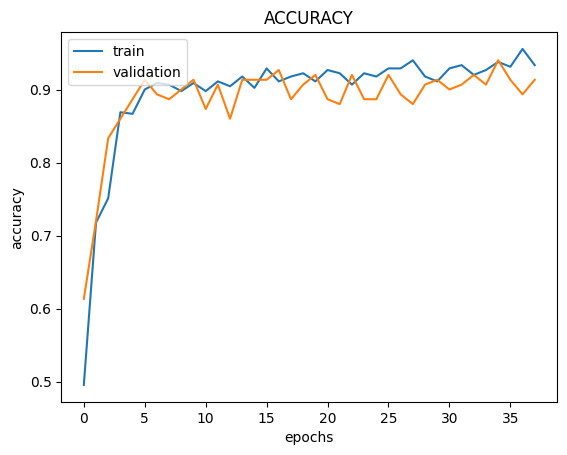

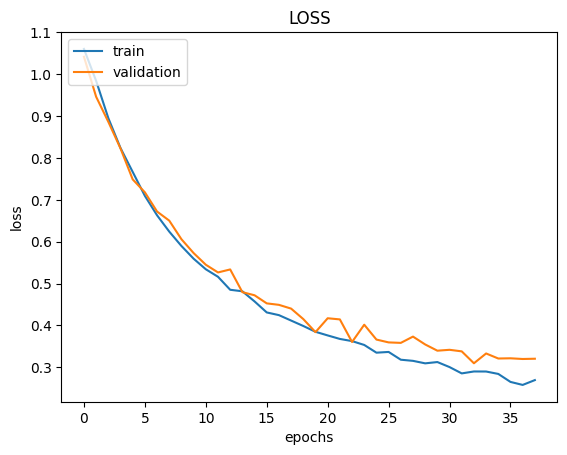

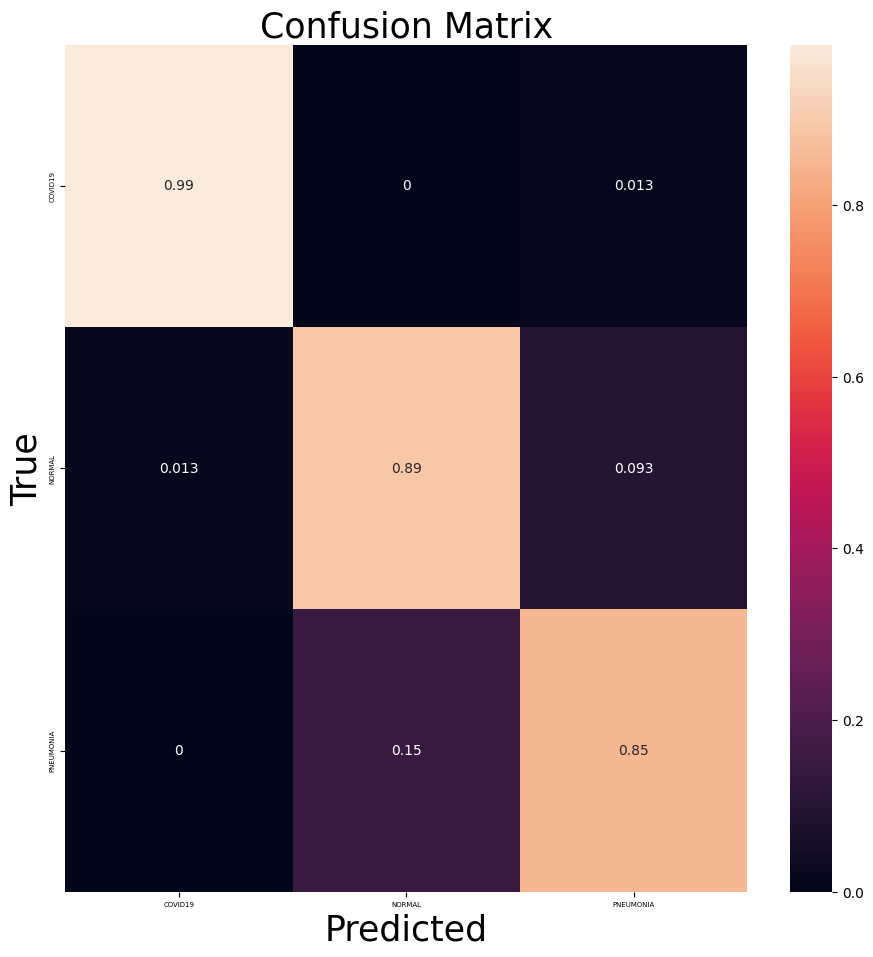

In [ ]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
for param_name, param in model.named_parameters():
    param.requires_grad = False
    
# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(model.fc.in_features, 3)
# for param_name, param in model.named_parameters():
#   print(param_name,param.requires_grad)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.0001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=2)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderIN, val_loaderIN, model, 60, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

num_epochs:  160  learning rate: 0.001
900/900: [===============================>] - ETA 0.3s
Epoch: 1
Training Loss: 0.993 , Training Accuracy:0.499 => Validation Loss: 0.883, Validation Accuracy: 0.593 
900/900: [===============================>] - ETA 0.4s
Epoch: 2
Training Loss: 0.810 , Training Accuracy:0.650 => Validation Loss: 0.779, Validation Accuracy: 0.670 
900/900: [===============================>] - ETA 0.4s
Epoch: 3
Training Loss: 0.725 , Training Accuracy:0.651 => Validation Loss: 0.736, Validation Accuracy: 0.637 
900/900: [===============================>] - ETA 0.4s
Epoch: 4
Training Loss: 0.683 , Training Accuracy:0.677 => Validation Loss: 0.688, Validation Accuracy: 0.700 
900/900: [===============================>] - ETA 0.3s
Epoch: 5
Training Loss: 0.664 , Training Accuracy:0.682 => Validation Loss: 0.703, Validation Accuracy: 0.630 
EarlyStopping Counter: 1 out of 17
900/900: [===============================>] - ETA 0.4s
Epoch: 6
Training Loss: 0.649 , Training 

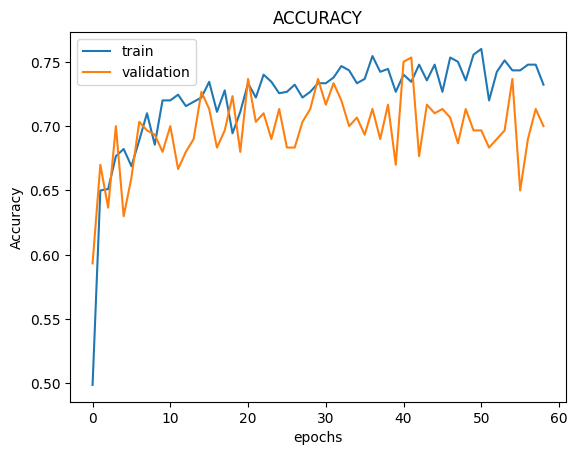

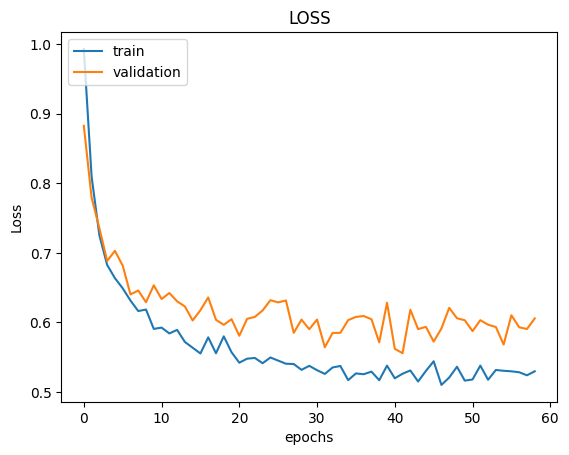

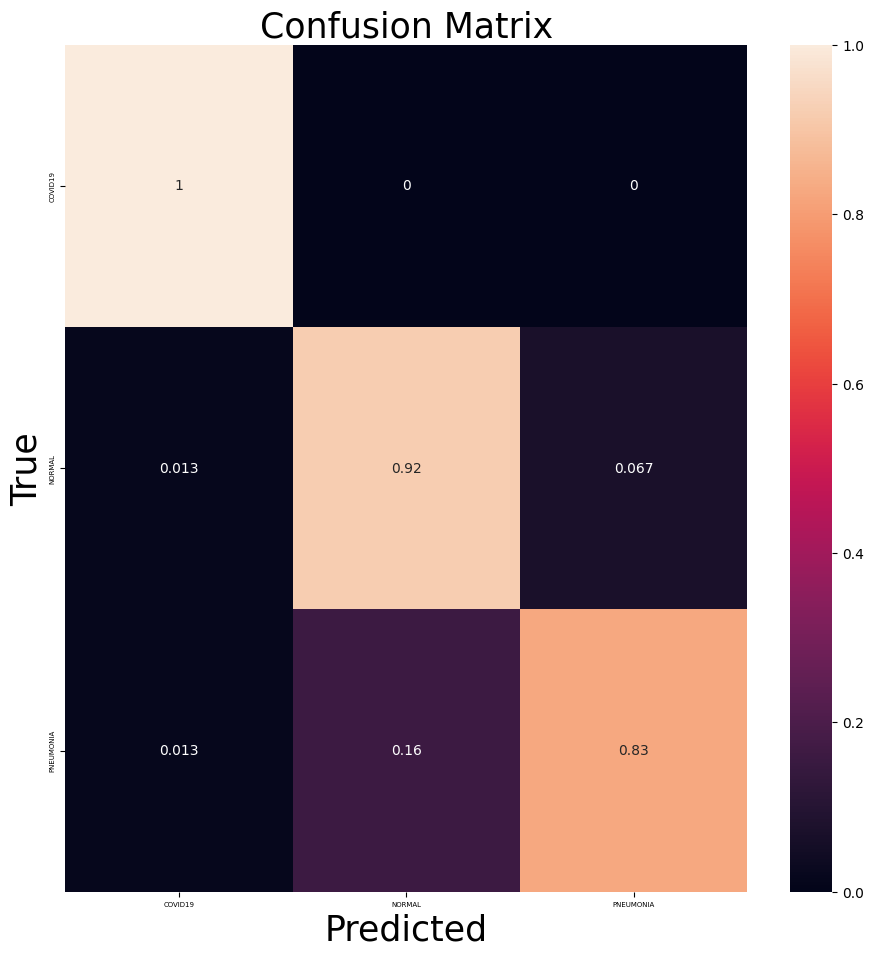

In [ ]:
# Last layer

# HINT:
#    - Training a ResNet50 (updating the last layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)


mean_imagenet=[0.485, 0.456, 0.406]
std_imagenet=[0.229, 0.224, 0.225]

model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(2048, num_classes)
model.to(device)

# let's unfreeze the fc2 layer this time for extra tuning
for param_name, param in model.named_parameters():
    param.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True



def get_transforms(height, width):
    # TODO: YOUR CODE HERE
    transform = normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean_imagenet, std_imagenet),
        torchvision.transforms.Resize((height, width)),
        torchvision.transforms.ToTensor(),
    ])
    return transform

def get_transforms_aug(height, width):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
        torchvision.transforms.GaussianBlur(kernel_size = (7,13), sigma=(0.1,.2)),
        torchvision.transforms.ToTensor(),
        AddGaussianNoise(0,1), #check that whther with mean=0 and std=1 works better
        torchvision.transforms.Resize((height, width)),

        torchvision.transforms.Normalize(mean_imagenet, std_imagenet),
        ])
    return transform


#Dataset
train_dataset_aug = torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=get_transforms_aug(height, width))
val_dataset_aug = torchvision.datasets.ImageFolder(root=val_dir,
                                               transform=get_transforms_aug(height, width))


train_dataset_both = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])
val_dataset_both = torch.utils.data.ConcatDataset([val_dataset, val_dataset_aug])

# Dataloaders
train_loader_both = torch.utils.data.DataLoader(train_dataset_both, batch_size=batch_size, shuffle=True)
val_loader_both = torch.utils.data.DataLoader(val_dataset_both, batch_size=batch_size, shuffle=True)




for num_epochs, lr in itertools.product([160],[1e-3]):
    print("num_epochs: ",num_epochs, " learning rate:", lr)
    # Optimizer and loss configurations
    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = optim.Adam(model.fc.parameters(),lr=lr)  # optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)  # learning rate scheduler


    # Initializing the early stopping of the training
    checkpoint_path = root_dir+"ResNet50_aug_last.pt"
    early_stopping = utils.EarlyStopping(checkpoint_path=checkpoint_path, patience=17, verbose=False, delta=0)


    # HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
    train_accuracy_both, val_accuracy_both, train_losses_both, val_losses_both = utils.run_training(train_loader_both, val_loader_both, model,
                                                                                num_epochs, criterion,
                                                                    optimizer, scheduler=scheduler,
                                                                    early_stopping=early_stopping, device=device)

    utils.get_metric_plots(train_accuracy_both, val_accuracy_both, metric_name="Accuracy")
    utils.get_metric_plots(train_losses_both, val_losses_both, metric_name="Loss")

    # Provide the testing dataset wrapped in a dataloader to check for inference
    model2 = torchvision.models.resnet50()
    model2.fc = nn.Linear(2048, num_classes)
    model2.to(device)
    model2.load_state_dict(torch.load(checkpoint_path))
    correct, total = utils.test_evaluation(model2, test_loader, device)
    cm = utils.get_confusion_matrix(classes, test_loader, model2, device, view_cm=True)
    utils.check_precision_recall_accuracy(cm, classes)
    print("num_epochs: ",num_epochs, " learning rate:", lr, "test_acc=", round(( correct / total),2) )
    utils.visualize_confusion_matrix(cm, classes, correct, total)
    print("------------------------")

**Questions**:

1. Elaborate on the reason to use pretrained ImageNet weights for transfer learning (instead of training from scratch).
2. Which transfer learning approach performs better for finetuning on our dataset? Comment on the possible reasons!
3. Explain the best use-cases for ImageNet pretrained weights for the two different approaches (i.e. when it is a good idea to train from scratch OR for finetuning all layers OR for finetuning last layers).

1.
Elaborate on the reason to use pretrained ImageNet weights for transfer learning (instead of training from scratch), if ImageNet already contains some structure that can be applied to our task, we can use it.

2.
Training only the last Layers works slightly better, probably because our dataset is too small to train all layer well and it has similar structures like the Imagenet dataset.

3.
When we have access to large dataset, it is best to train the model based on our own dataset. This way, our model learns the latent space of our own dataset and hence it is probable that it performs well on the test set. When our dataset is limited, employing the weights from the pretarined models is more faivorable as the parameters of the pretrained model already learned complex features during initial training with large variety of data.


**Comment:** When finetuning a model it may also be beneficial to use a different learning rate and change other hyperparameters compared to training from scratch. To keep the exercise simple we do not further explore these options here. If you're interested to investigate these effects you can explore different hyperparameters at the end of the exercise.

## RadImageNet

A disadvantage of using ImageNet pretraining for medical images is that the pretraining data is very different to medical images. There are several efforts to build pretraining datasets for the medical image domain, for example [RadImageNet](https://www.radimagenet.com/).
It contains a pretraining dataset made up of radiology images of a comparable size to ImageNet and provides networks that were pretrained with this dataset.
- For more details you can check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

Note: if you use on RadImageNet weights you will have to use the statistics below for normalization (corresponding to the image statistics of the RadImageNet dataset):
```python
# Normalization: mean and standard deviation values for the pretrained weights on radimagenet dataset
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)
```

We now use pretrained RadImageNet weights for the ResNet50. For this we first need to download those weights and then initialize the architecture correctly. (This is a bit more complex compared to before, so we give you the code for this below.)

In [ ]:
transform_RI =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=(0.223, 0.223, 0.223), std=(0.203, 0.203, 0.203)),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
train_loaderRI,val_loaderRI=get_DataLoader(transform_RI)

transform_RIt =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=(0.223, 0.223, 0.223), std=(0.203, 0.203, 0.203)),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
test_datasetRI = torchvision.datasets.ImageFolder(test_dir,transform_RIt)
test_loaderRI = torch.utils.data.DataLoader(test_datasetRI,batch_size,True)

In [ ]:
# DO NOT CHANGE
# downloading the radimagenet pretrained model weights
# radimagenet weights - https://drive.google.com/file/d/1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR/view
! gdown 1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR
!unzip -q "/content/RadImageNet_pytorch.zip" -d "RadImageNet_Models"

Downloading...
From: https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR
To: /content/RadImageNet_pytorch.zip
100% 195M/195M [00:02<00:00, 71.8MB/s]


In [ ]:
# DO NOT CHANGE
radimagenet_checkpoint_path = "/content/RadImageNet_Models/RadImageNet_pytorch"

resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"))

In [ ]:
# DO NOT CHANGE
# We create the backbone to intialize it with the pretrained weights from radimagenet
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = torchvision.models.resnet50()
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])

    def forward(self, x):
        return self.backbone(x)


# We build the classifier to use the features for transfer learning
class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x

## Architecture

We now combine the backbone (ResNet50 pretrained on RadImageNet) and the classification layer for our dataset.

Train and evaluate this model. You can decide wheter to finetune the whole model or just the last layer.

In [ ]:
# Let's call the backbone (the encoder excluding the last layers)
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))

# Finally, we are ready to build our model
net = nn.Sequential(backbone, classifier)

In [ ]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating all / last layers, transfer learning using RadImageNet weights)
#    = (the training workflows are the same as above)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-full-from-RadImageNet.pt
Starting training from scratch with network:  resnet50-full
450/450: [==============================>.] - ETA 0.5s
Epoch: 1
Training Loss: 1.094 , Training Accuracy:0.404 => Validation Loss: 1.055, Validation Accuracy: 0.400 
450/450: [==============================>.] - ETA 0.4s
Epoch: 2
Training Loss: 1.054 , Training Accuracy:0.469 => Validation Loss: 1.032, Validation Accuracy: 0.573 
450/450: [==============================>.] - ETA 0.3s
Epoch: 3
Training Loss: 1.029 , Training Accuracy:0.664 => Validation Loss: 1.010, Validation Accuracy: 0.667 
450/450: [==============================>.] - ETA 0.3s
Epoch: 4
Training Loss: 0.996 , Training Accuracy:0.731 => Validation Loss: 0.986, Validation Accuracy: 0.687 
450/450: [==============================>.] - ETA 0.3s
Epoch: 5
Training Loss: 0.969 , Training Accuracy:0.727 => Validation Loss: 0.957, Validation Accuracy: 0.733 

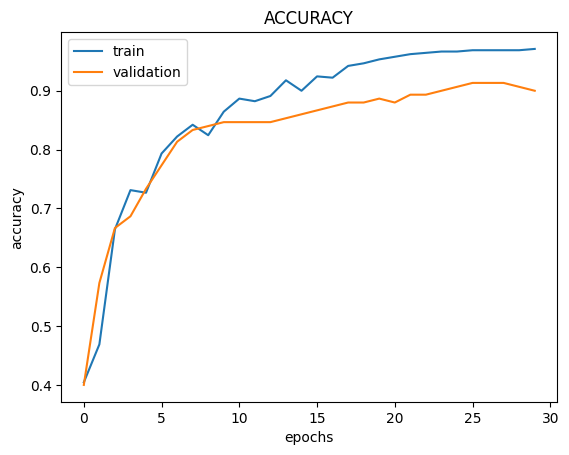

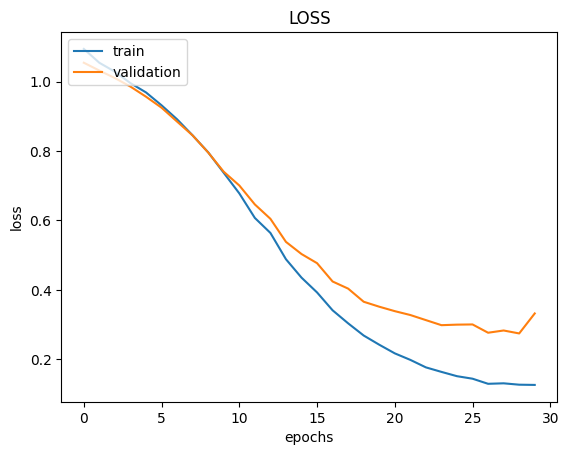

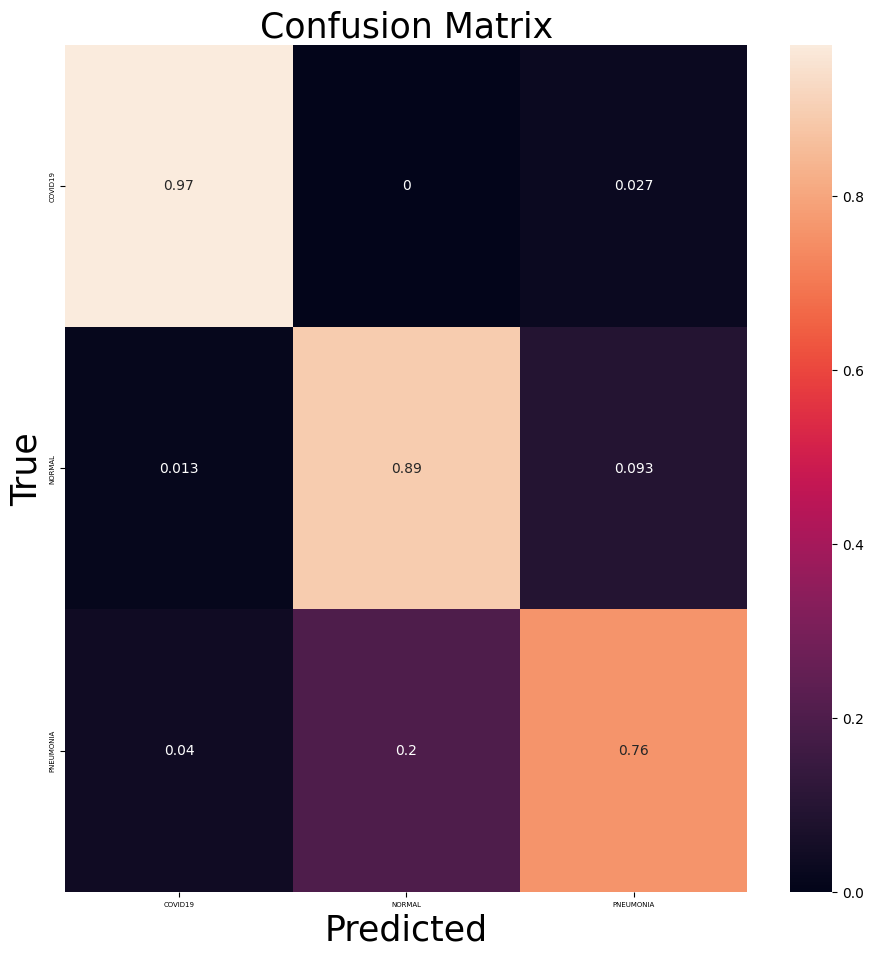

In [ ]:
model =net
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50-full"
checkpoint_name = f'covid-19-{model_name}-from-RadImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderRI, val_loaderRI, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

correct, total = utils.test_evaluation(model, test_loaderRI, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderRI, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

num_epochs:  160  learning rate: 0.001
900/900: [===============================>] - ETA 0.6s
Epoch: 1
Training Loss: 1.062 , Training Accuracy:0.436 => Validation Loss: 0.870, Validation Accuracy: 0.557 
900/900: [===============================>] - ETA 0.5s
Epoch: 2
Training Loss: 0.823 , Training Accuracy:0.562 => Validation Loss: 0.846, Validation Accuracy: 0.533 
900/900: [===============================>] - ETA 0.5s
Epoch: 3
Training Loss: 0.860 , Training Accuracy:0.520 => Validation Loss: 0.817, Validation Accuracy: 0.557 
900/900: [===============================>] - ETA 0.5s
Epoch: 4
Training Loss: 0.781 , Training Accuracy:0.600 => Validation Loss: 0.726, Validation Accuracy: 0.607 
900/900: [===============================>] - ETA 0.5s
Epoch: 5
Training Loss: 0.693 , Training Accuracy:0.612 => Validation Loss: 0.777, Validation Accuracy: 0.580 
EarlyStopping Counter: 1 out of 17
900/900: [===============================>] - ETA 0.6s
Epoch: 6
Training Loss: 0.659 , Training 

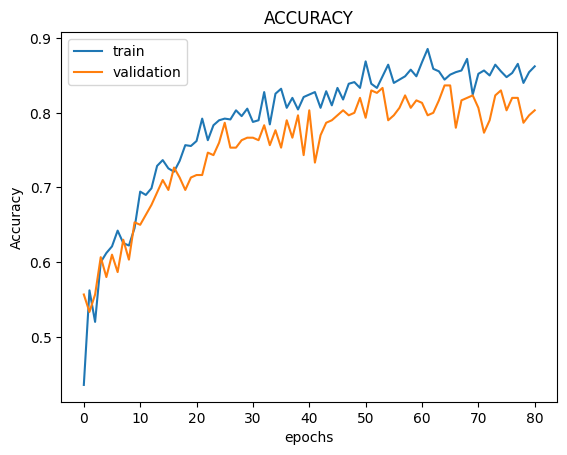

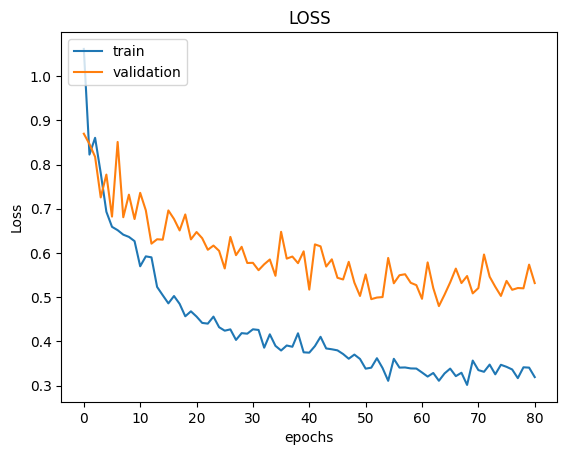

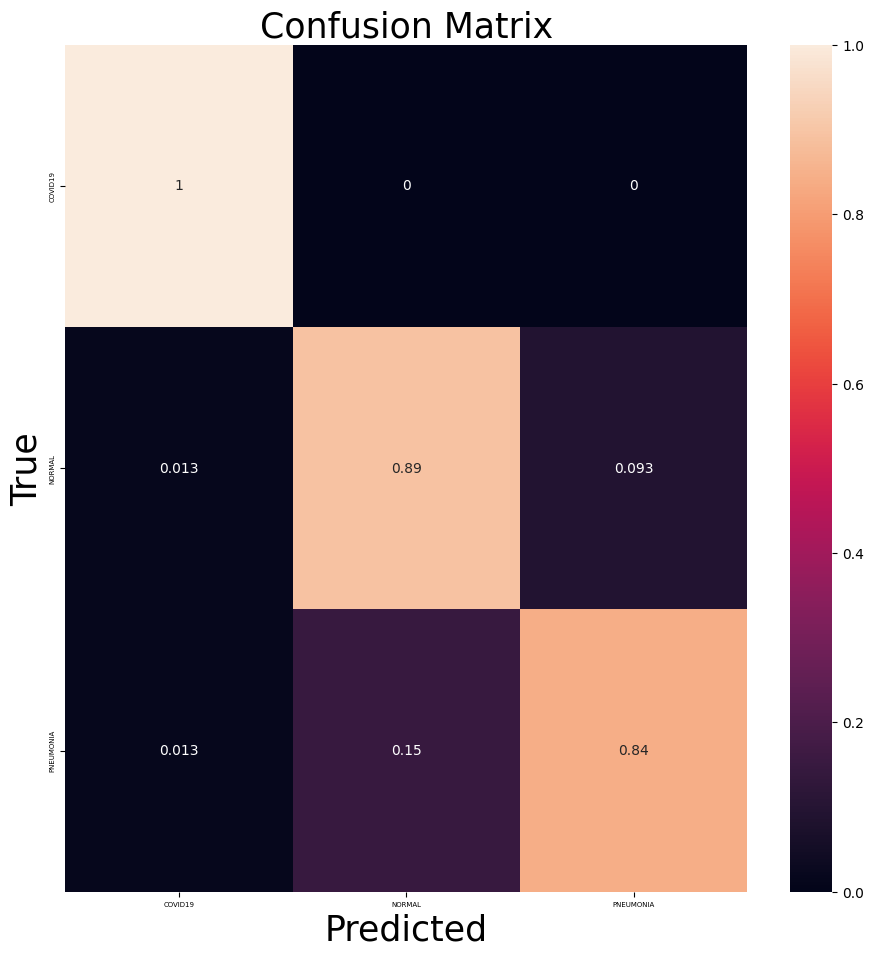

In [ ]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating all / last layers, transfer learning using RadImageNet weights)
#    = (the training workflows are the same as above)

##All layers


radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)

def get_transforms(height, width):
    # TODO: YOUR CODE HERE
    transform = normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(radimagenet_mean, radimagenet_std),
        torchvision.transforms.Resize((height, width)),

    ])
    return transform

def get_transforms_aug(height, width):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
        torchvision.transforms.GaussianBlur(kernel_size = (7,13), sigma=(0.1,.2)),
        torchvision.transforms.ToTensor(),
        AddGaussianNoise(0,1), #check that whther with mean=0 and std=1 works better
        torchvision.transforms.Resize((height, width)),
        torchvision.transforms.Normalize(radimagenet_mean, radimagenet_std),
        ])
    return transform


#Dataset
train_dataset_aug = torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=get_transforms_aug(height, width))
val_dataset_aug = torchvision.datasets.ImageFolder(root=val_dir,
                                               transform=get_transforms_aug(height, width))


train_dataset_both = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])
val_dataset_both = torch.utils.data.ConcatDataset([val_dataset, val_dataset_aug])

# Dataloaders
train_loader_both = torch.utils.data.DataLoader(train_dataset_both, batch_size=batch_size, shuffle=True)
val_loader_both = torch.utils.data.DataLoader(val_dataset_both, batch_size=batch_size, shuffle=True)

for num_epochs, lr in itertools.product([160],[1e-3]):
    print("num_epochs: ",num_epochs, " learning rate:", lr)
    # Optimizer and loss configurations
    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = optim.Adam(model.parameters(),lr=lr)  # optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, factor=0.3)  # learning rate scheduler


    # Initializing the early stopping of the training
    checkpoint_path = root_dir+"ResNet50_radimg_full.pt"
    early_stopping = utils.EarlyStopping(checkpoint_path=checkpoint_path, patience=17, verbose=False, delta=0)


    # HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
    train_accuracy_both, val_accuracy_both, train_losses_both, val_losses_both = utils.run_training(train_loader_both, val_loader_both, model,
                                                                                num_epochs, criterion,
                                                                    optimizer, scheduler=scheduler,
                                                                    early_stopping=early_stopping, device=device)

    utils.get_metric_plots(train_accuracy_both, val_accuracy_both, metric_name="Accuracy")
    utils.get_metric_plots(train_losses_both, val_losses_both, metric_name="Loss")

    # Provide the testing dataset wrapped in a dataloader to check for inference
    model2 = nn.Sequential(backbone, classifier)
    model2.to(device)
    model2.load_state_dict(torch.load(checkpoint_path))
    correct, total = utils.test_evaluation(model2, test_loader, device)
    cm = utils.get_confusion_matrix(classes, test_loader, model2, device, view_cm=True)
    utils.check_precision_recall_accuracy(cm, classes)
    print("num_epochs: ",num_epochs, " learning rate:", lr, "test_acc=", round((correct / total),2) )
    utils.visualize_confusion_matrix(cm, classes, correct, total)
    print("------------------------")

In [ ]:
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))
for param_name, param in backbone.named_parameters():
    param.requires_grad = False
# Let's replace the "fully connected" layer to match our expected output classes
net = nn.Sequential(backbone, classifier)




The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-onlyClassifier-from-RadImageNet.pt
Starting training from scratch with network:  resnet50-onlyClassifier
450/450: [==============================>.] - ETA 0.3s
Epoch: 1
Training Loss: 1.158 , Training Accuracy:0.302 => Validation Loss: 1.109, Validation Accuracy: 0.287 
450/450: [==============================>.] - ETA 0.2s
Epoch: 2
Training Loss: 1.102 , Training Accuracy:0.293 => Validation Loss: 1.103, Validation Accuracy: 0.287 
450/450: [==============================>.] - ETA 0.2s
Epoch: 3
Training Loss: 1.093 , Training Accuracy:0.356 => Validation Loss: 1.097, Validation Accuracy: 0.327 
450/450: [==============================>.] - ETA 0.2s
Epoch: 4
Training Loss: 1.087 , Training Accuracy:0.416 => Validation Loss: 1.091, Validation Accuracy: 0.393 
450/450: [==============================>.] - ETA 0.2s
Epoch: 5
Training Loss: 1.084 , Training Accuracy:0.420 => Validation Loss: 1.087, Validat

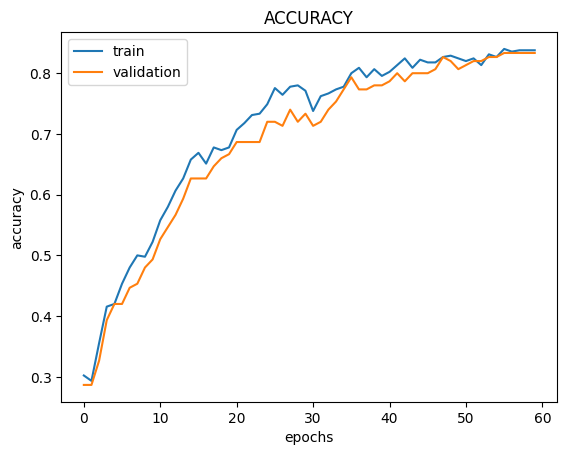

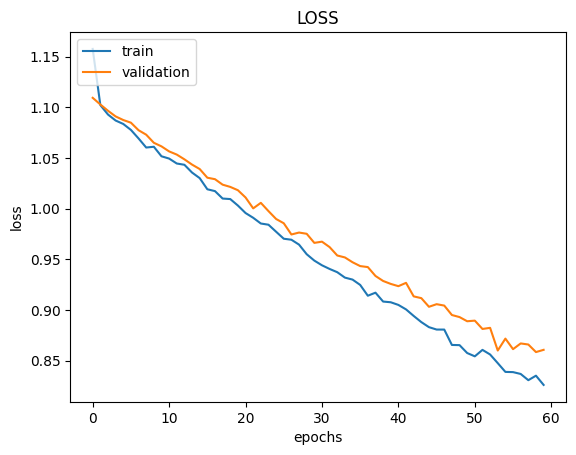

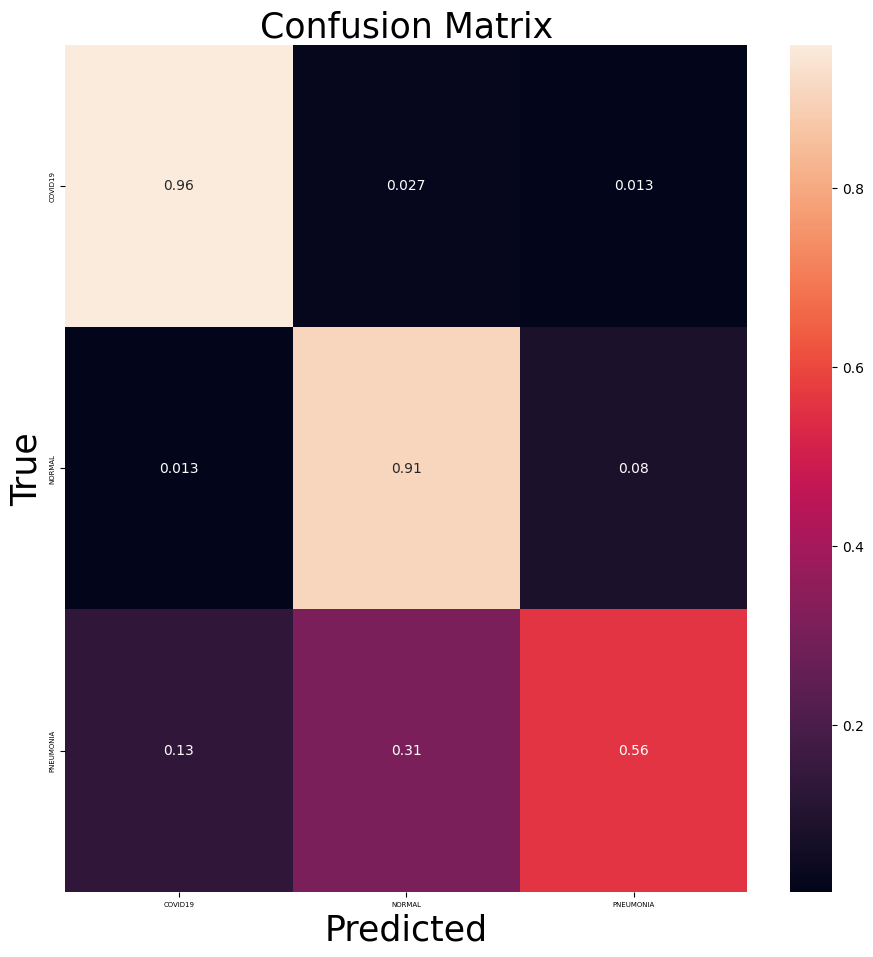

In [ ]:
model =net
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50-onlyClassifier"
checkpoint_name = f'covid-19-{model_name}-from-RadImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=2)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderRI, val_loaderRI, model, 60, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

# backbone = Backbone()
# backbone.load_state_dict(resnet50_ckpt)
# classifier = Classifier(num_class=len(classes))
# net = nn.Sequential(backbone, classifier)
# model = net
# model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
# model.to(device)


correct, total = utils.test_evaluation(model, test_loaderRI, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderRI, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

num_epochs:  160  learning rate: 0.001


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


900/900: [===============================>] - ETA 0.6s
Epoch: 1
Training Loss: 1.078 , Training Accuracy:0.424 => Validation Loss: 0.950, Validation Accuracy: 0.517 
900/900: [===============================>] - ETA 0.7s
Epoch: 2
Training Loss: 0.932 , Training Accuracy:0.524 => Validation Loss: 0.834, Validation Accuracy: 0.627 
900/900: [===============================>] - ETA 0.3s
Epoch: 3
Training Loss: 0.834 , Training Accuracy:0.609 => Validation Loss: 0.810, Validation Accuracy: 0.620 
900/900: [===============================>] - ETA 0.3s
Epoch: 4
Training Loss: 0.798 , Training Accuracy:0.629 => Validation Loss: 0.806, Validation Accuracy: 0.610 
900/900: [===============================>] - ETA 0.4s
Epoch: 5
Training Loss: 0.799 , Training Accuracy:0.623 => Validation Loss: 0.838, Validation Accuracy: 0.600 
EarlyStopping Counter: 1 out of 20
900/900: [===============================>] - ETA 0.3s
Epoch: 6
Training Loss: 0.763 , Training Accuracy:0.638 => Validation Loss: 0.80

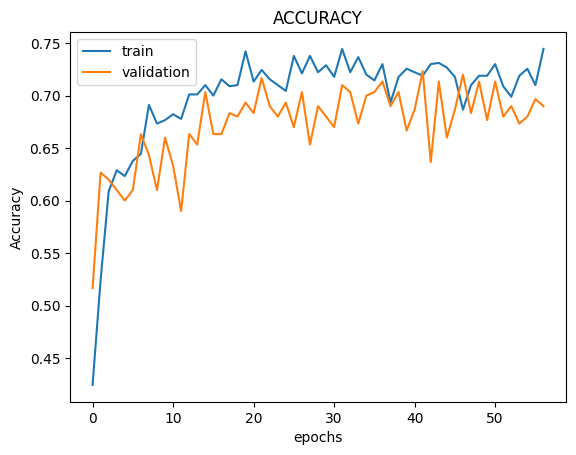

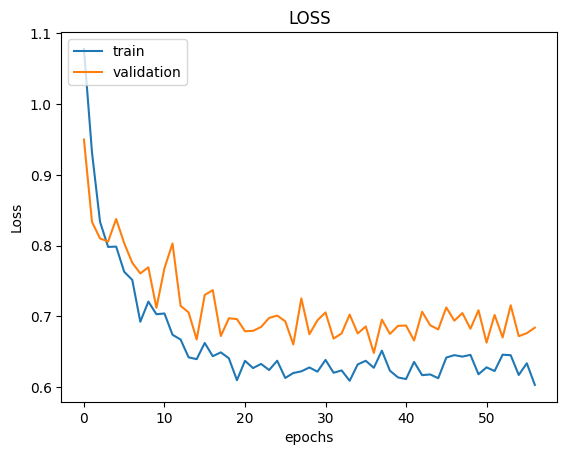

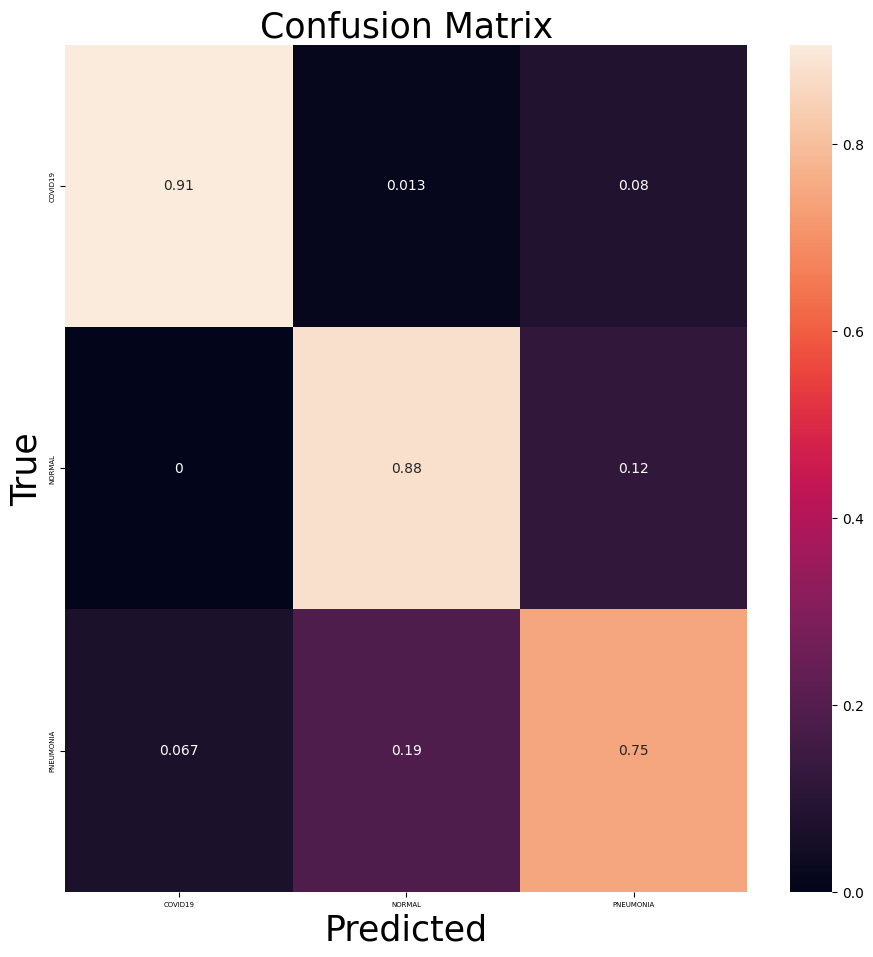

In [ ]:
# Let's call the backbone (the encoder excluding the last layers)
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))

# Finally, we are ready to build our model
model = nn.Sequential(backbone, classifier)

i=0
for param_name, param in model.named_parameters():
    # print(param_name, i)
    param.requires_grad = False
    if i>=159:
        param.requires_grad = True
    i = i+1
model.to(device)
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.classifier.parameters():
#     param.requires_grad = True


def get_transforms(height, width):
    # TODO: YOUR CODE HERE
    transform = normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(radimagenet_mean, radimagenet_std),
        torchvision.transforms.Resize((height, width)),
        torchvision.transforms.ToTensor(),
    ])
    return transform

def get_transforms_aug(height, width):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
        torchvision.transforms.GaussianBlur(kernel_size = (7,13), sigma=(0.1,.2)),
        torchvision.transforms.ToTensor(),
        AddGaussianNoise(0,1), #check that whther with mean=0 and std=1 works better
        torchvision.transforms.Resize((height, width)),

        torchvision.transforms.Normalize(radimagenet_mean, radimagenet_std),
        ])
    return transform


#Dataset
train_dataset_aug = torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=get_transforms_aug(height, width))
val_dataset_aug = torchvision.datasets.ImageFolder(root=val_dir,
                                               transform=get_transforms_aug(height, width))


train_dataset_both = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])
val_dataset_both = torch.utils.data.ConcatDataset([val_dataset, val_dataset_aug])

# Dataloaders
train_loader_both = torch.utils.data.DataLoader(train_dataset_both, batch_size=batch_size, shuffle=True)
val_loader_both = torch.utils.data.DataLoader(val_dataset_both, batch_size=batch_size, shuffle=True)




for num_epochs, lr in itertools.product([160],[1e-3]):
    print("num_epochs: ",num_epochs, " learning rate:", lr)
    # Optimizer and loss configurations
    criterion = nn.CrossEntropyLoss()  # loss function
    optimizer = optim.Adam(model.parameters(),lr=lr)  # optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, factor=0.2)  # learning rate scheduler
#     scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
#                                                                 T_0=100,
#                                                                 T_mult=1,
#                                                                 eta_min=0.0001,
#                                                                 last_epoch=-1,
#                                                                 verbose = True)

    # Initializing the early stopping of the training
    checkpoint_path =root_dir+"ResNet50_radimag_lastlayer.pt"
    early_stopping = utils.EarlyStopping(checkpoint_path=checkpoint_path, patience=20, verbose=False, delta=0)


    # HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
    train_accuracy_both, val_accuracy_both, train_losses_both, val_losses_both = utils.run_training(train_loader_both, val_loader_both, model,
                                                                                num_epochs, criterion,
                                                                    optimizer, scheduler=scheduler,
                                                                    early_stopping=early_stopping, device=device)

    utils.get_metric_plots(train_accuracy_both, val_accuracy_both, metric_name="Accuracy")
    utils.get_metric_plots(train_losses_both, val_losses_both, metric_name="Loss")

    # Provide the testing dataset wrapped in a dataloader to check for inference
    model2 = nn.Sequential(backbone, classifier)
    model2.to(device)
    model2.load_state_dict(torch.load(checkpoint_path))
    correct, total = utils.test_evaluation(model2, test_loader, device)
    cm = utils.get_confusion_matrix(classes, test_loader, model2, device, view_cm=True)
    utils.check_precision_recall_accuracy(cm, classes)
    print("num_epochs: ",num_epochs, " learning rate:", lr, "test_acc=", round((correct / total),2) )
    utils.visualize_confusion_matrix(cm, classes, correct, total)
    print("------------------------")

**Questions**:

1. Comment on your choice of transfer learning approach (either finetuning last layers / all layers in the model) for RadImageNet? Why could the best approach here be different from ImageNet?

**Answer**
As the RadImage dataset is very similar to our dataset, using the pretarined model and its weights is a better option. This is opposite to the ImageNet dataset which was different from our dataset and training from scratch ends up with a better performance.

### Overall Results:

Update the table with your results for all experiments from the exercise:

| Model    | Training                         | Test Accuracy |
|:-------: |:--------------------------------:|:-------------:|
| ResNet18 | from scratch                     | 86              |
| ResNet34 | from scratch                     | 87              |
| ResNet50 | from scratch                     | 77              |
| ResNet50 | from scratch (with augmentation) | 90              |
| ResNet50 | from ImageNet (all layers)       | 90              |
| ResNet50 | from ImageNet (last layers)      | 91              |
| ResNet50 | from RadImageNet                 | 87            |

**Question**:
1. Comment on the trend observed in the results from the table.
2. Which is the overall best model? Does this match your expectations? Why/why not?

**Important: please read the end of the exercise sheet and upload the predictions from your best model, also if you choose not to try out to further improve it.**

**Answer**

1.The performance of ResNet50 is over better as the model is larger and more parameters are trained to learn higher-order features. We further observe that training all layers is associated with larger test accuracy.

2.The ResNet50 with full layers training performs the best. We initially expect that ResNet with RadImage results in a higher test acuuracy as its training dataset was more similar to ur dataset. This might be due to the hyperparameters used in the pretraining the initial model.

## (OPTIONAL): Further improve your model.

You can now try to further improve the model by using different architectures or trying some of the advanced training and inference techniques discussed in the lecture. This part of the exercise is optional, and you can try to apply as many approaches for improving your method as you would like. If you don't want to work on the optional part at all please go to the end of the exercise to submit the predictions from your best model.

Here are the aproaches you can try to improve the model:
1. Update the training hyperparameter:
    - You can choose a better initial learning rate, or choose different options for the learning rate scheduler or early stopping.
    - The most important parameter is probably the learning rate; if you want to improve it then train only for a short time and compare different values. (Remember lecture 2 and the first exercise).
2. Try other architectures provided in `torchvision.models`, which implements further CNN architectures (and their respective ImageNet pretrained weights). For example `DenseNet` or `EfficientNet` could yield better results than ResNets.
    - `torchvision.models` also offers vision transformer architectures (https://arxiv.org/abs/2010.11929). We will cover those later in the lecture, but if you want you can try them here as well. See the snippet at the end of this section for details.
3. Try advanced data augmentation strategies, which change the data manifold severly and can boost performance. For example MixUp or CutMix. `torchivsion` already implements them, see [data augmentation with torchvision](https://pytorch.org/vision/stable/transforms.html) for details.
4. Try test-time data augmentation. We have covered this idea in the lecture. To use it you don't need to change the training at all, but just update the model prediction during testing. Fot this you can either update the functionality in `ex3_utils.py` or implement a wrapper function or class around the model that implements the test-time data augmentation logic.
5. Try model ensembling: combine the predictions of different models on the test set or use an implicit averaging approach like polyak averaging. For this approaches you may need to update the training and/or prediction functions from `ex3_utils.py`.

Here's a snippet that shows how to use vision transformers from torchvision:

```python
# replacing the respective layers of the "transformer-based networks" to match our number of classes
net = torchvision.models.vit_b_16(pretrained=True)
net.heads.head = nn.Linear(768, num_classes)
net.to(device)
```

**Hint**: if you want to systematically improve your model you should proceed as follows:
- Decide on the base architecture and how to initialize it.
    - Either choose the best model you according to the exercise so far or try if advanced architectures from `torchvision` bring an improvement and continue with one of them.
- Optimize the training hyperparameters (learning rate, scheduling, early stopping).
- Investigate advanced techniques:
  - Training with more or advanced data augmentation.
  - Test-time data augmentation
  - Model ensembling

You can divide some of these tasks up among your group and train the best model by combining the best settings you have found for the individual steps.

## Train your best model

In [ ]:
from barbar import Bar
from torchvision.transforms import v2

cutmix = v2.CutMix(num_classes=3)
mixup = v2.MixUp(num_classes=3)
cutmix_or_mixup = v2.RandomChoice([mixup,cutmix])

def run_training(
        train_loader, val_loader, net, num_epochs, criterion, optimizer, scheduler=None, early_stopping=None, device="cpu", b_transformer=False
):
    """This function runs the training scheme for the training dataset, and validates on the validation dataset as well

    Arguments:
        train_loader: The training dataloader
        val_loader: The validation dataloader
        net: The model architecture to perform the training on
        num_epochs: The total number of epochs to train the models for
        criterion: The loss function
        optimizer: The optimizer object
        scheduler: The learning rate scheduler (the workflow is suited right now for `ReduceLROnPlateau`)
        early_stopping: The early stopping functionality
        device: The torch device

    Returns:
        accuracy: The accuracy on training set
        val_accuracy: The accuracy on validation set
        losses: The losses on training set (per epoch)
        val_losses: The losses on validation set (per epoch)
    """
    accuracy, val_accuracy = [], []
    losses, val_losses = [], []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_total = 0.0
        num_samples_total = 0.0
        for i, data in enumerate(Bar(train_loader)):
            # getting the training inputs
            inputs, labels = data
            if b_transformer:
              inputs, labels = cutmix_or_mixup(inputs, labels)
            inputs, labels = inputs.to(device), labels.to(device)

            # setting the parameter gradients to zero
            optimizer.zero_grad()

            # forward pass, backward pass, optimize
            outputs = net(inputs)

            t = torch.cuda.get_device_properties(0).total_memory
            r = torch.cuda.memory_reserved(0)
            a = torch.cuda.memory_allocated(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # computing accuracy
            #_, predicted = torch.max(outputs, 1)
            #b_len, corr = get_accuracy(predicted, labels)
            #corr = (outputs == labels).sum()
            b_len=labels.size(0)

            num_samples_total += b_len
            #correct_total += corr
            running_loss += loss.item()

            #t = torch.cuda.get_device_properties(0).total_memory
            #r = torch.cuda.memory_reserved(0)
            #a = torch.cuda.memory_allocated(0)
            #f = r-a

            #print(int(r/1000000)/1000,int(a/1000000)/1000,int(f/1000000)/1000)

        running_loss /= len(train_loader)
        #train_accuracy = correct_total / num_samples_total
        val_loss, val_acc = evaluate(net, criterion, val_loader, device)

        #del(labels)
        #del(inputs)
        #del(outputs)

        if scheduler is not None:
            # decay the learning rate
            if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
                # here, you can potentially track on either of the two metrics: val loss or val accuracy
                scheduler.step(val_loss)
            else:
                scheduler.step()

        #t = torch.cuda.get_device_properties(0).total_memory
        #r = torch.cuda.memory_reserved(0)
        #a = torch.cuda.memory_allocated(0)
        f = r-a
        #print("/n")
        print(int(r/1000000)/1000,int(a/1000000)/1000,int(f/1000000)/1000)

        print('Epoch: %d' % (epoch + 1))
        print('Training Loss: %.3f => Validation Loss: %.3f, Validation Accuracy: %.3f ' % (running_loss, val_loss, val_acc))

        losses.append(running_loss)  # list containing the training losses
        val_losses.append(val_loss)  # list containing the validation losses
        #accuracy.append(train_accuracy)  # list containing the training accuracy
        val_accuracy.append(val_acc)  # list containing the validation accuracy

        if early_stopping is not None:
            # early stopping needs to check the validation loss if it decreases, and saves checkpoint of current best model
            early_stopping(val_loss, net)

            if early_stopping.early_stop:
                print("Early Stopping...")
                break

    print('Finished Training')
    return accuracy, val_accuracy, losses, val_losses


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a

print(t,r,a,f)

15835398144 429916160 225671680 204244480


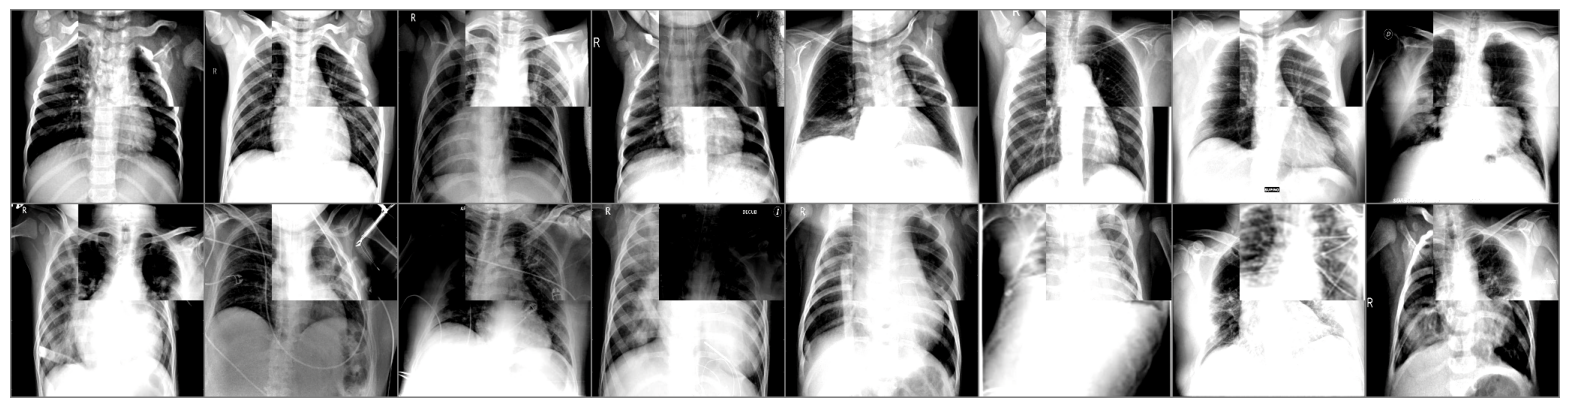

In [ ]:
fig = plt.figure(figsize=(20, 25))
def imshow(img):
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels=cutmix_or_mixup(images, labels)
# Show the images
imshow(torchvision.utils.make_grid(images))

#print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
batch_size=4
transform_IN =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.75),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
train_loaderIN,val_loaderIN=get_DataLoader(transform_IN,batch_size)

transformIN_t =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
        ])
test_datasetIN = torchvision.datasets.ImageFolder(test_dir,transformIN_t)
test_loaderIN = torch.utils.data.DataLoader(test_datasetIN,batch_size,True)

In [ ]:
class Combind(nn.Module):
  def __init__(self):
    super().__init__()
    #self.regnet=torchvision.models.regnet_x_32gf(weights=torchvision.models.RegNet_X_32GF_Weights.DEFAULT)
    #self.densenet=torchvision.models.densenet201(weights=torchvision.models.DenseNet201_Weights.DEFAULT)
    self.VGG=torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)
    #self.res=torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    #self.vit=torchvision.models.vit_b_16(pretrained=True)
    self.resnext=torchvision.models.resnext101_32x8d(weights = True)
    self.cls=nn.Linear(2000,3)
  def forward(self, i):
      #x=self.densenet(i)
      x=self.resnext(i)
      #x=self.VGG(i)
      #x=self.res(i)
      #x=self.regnet(i)
      #x=self.vit(transforms.Resize((224, 224))(i))
      x=torch.cat((x, self.VGG(i)), dim=1)
      #x=(x+self.res(i))/2
      #x=(x+self.vit(transforms.Resize((224, 224))(i)))/2
      return self.cls(nn.ReLU()(x))


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 72.8MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:04<00:00, 81.4MB/s]


The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-Combind_VGG_resnext-from-ImageNet.pt
Starting training with network:  Combind_VGG_resnext
450/450: [===============================>] - ETA 0.5s
6.406 3.894 2.512
Epoch: 1
Training Loss: 0.391 => Validation Loss: 0.182, Validation Accuracy: 0.933 
450/450: [===============================>] - ETA 0.5s
7.459 3.894 3.564
Epoch: 2
Training Loss: 0.197 => Validation Loss: 0.438, Validation Accuracy: 0.807 
EarlyStopping Counter: 1 out of 7
450/450: [===============================>] - ETA 0.4s
7.459 3.894 3.564
Epoch: 3
Training Loss: 0.132 => Validation Loss: 0.252, Validation Accuracy: 0.887 
EarlyStopping Counter: 2 out of 7
450/450: [===============================>] - ETA 0.4s
7.459 3.894 3.564
Epoch: 4
Training Loss: 0.124 => Validation Loss: 0.153, Validation Accuracy: 0.947 
450/450: [===============================>] - ETA 0.5s
7.459 3.894 3.564
Epoch: 5
Training Loss: 0.091 => Validation Loss: 0.171, Val

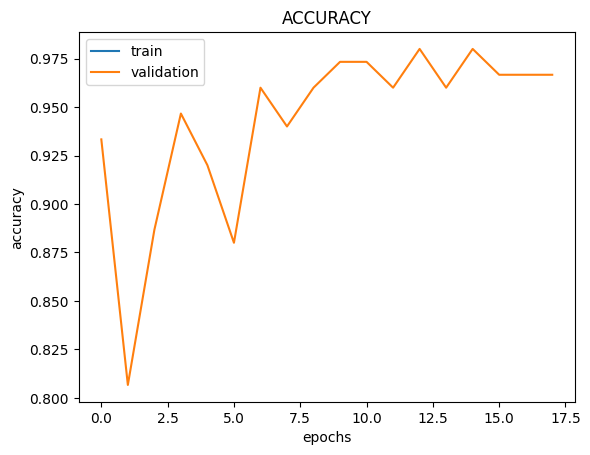

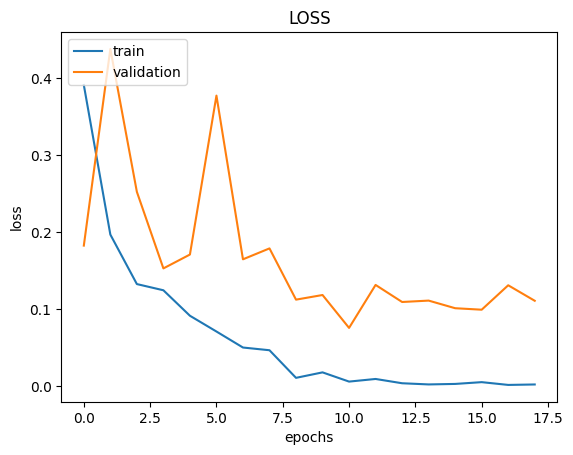

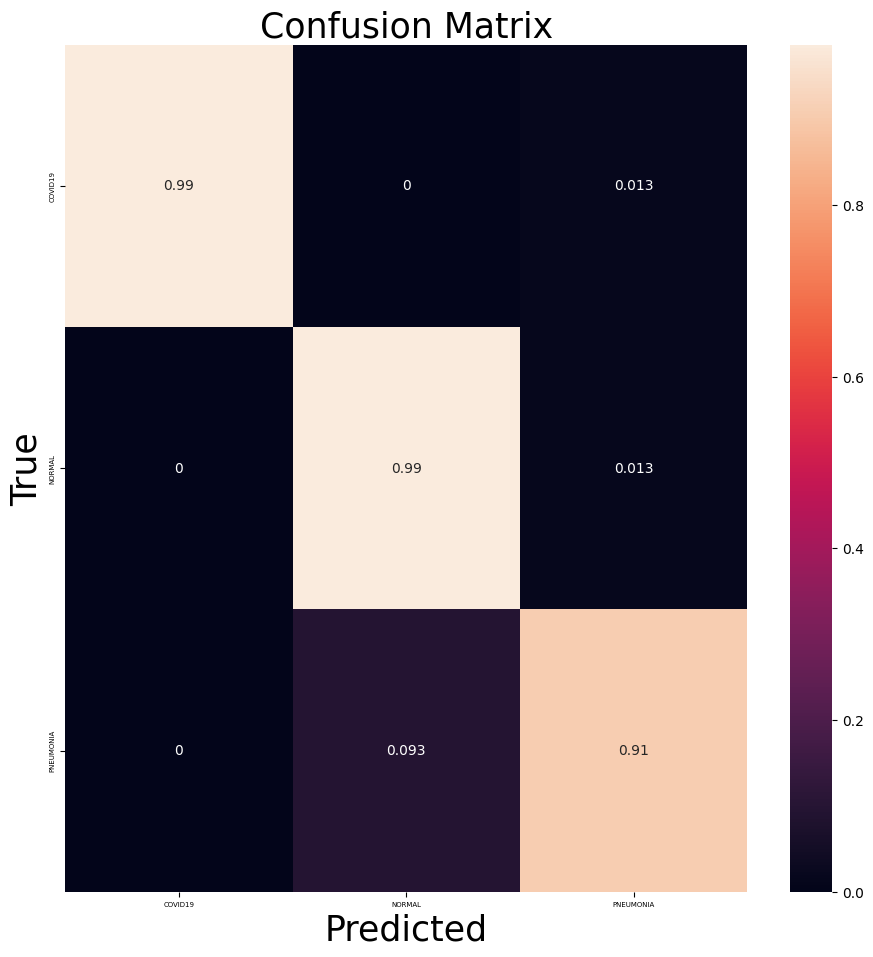

In [ ]:
#torch.cuda.empty_cache()

#model=torchvision.models.resnext101_32x8d(weights = True)
model=Combind()
model.to(device)

# print('resnet architecture: ')
# children_counter = 0
# for n, c in model.named_children():
#     print("Children Counter: ",children_counter," Layer Name: ",n,)
#     children_counter += 1
# print(model.classifier)

# Classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=True),
#   nn.Linear(in_features=2560, out_features=3, bias=True)
# )
# for parameter in model.parameters():
#     parameter.requires_grad = False
# model.classifier = Classifier
# model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "Combind_VGG_resnext"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.00001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=3)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path,patience=7)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = run_training(
    train_loaderIN, val_loaderIN, model, 100, criterion, optimizer, scheduler, early_stopping, device,b_transformer=False)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

model.load_state_dict(torch.load(checkpoint_path))
model.to(device)


correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

In [ ]:
transform_Max =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(),
        #AddGaussianNoise(),
        transforms.Resize((512, 512))
    ])
transform_Maxt =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(),
        #AddGaussianNoise(),
        transforms.Resize((512, 512))
    ])
train_loaderMax,val_loaderMax=get_DataLoader(transform_Max)
test_datasetMax = torchvision.datasets.ImageFolder(test_dir,transform_Maxt)
test_loaderMax = torch.utils.data.DataLoader(test_datasetMax,batch_size,True)

In [ ]:
next(iter(train_loaderMax))[0].shape

torch.Size([16, 1, 512, 512])

In [ ]:
transform_vit =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((224, 224))
    ])
train_loadervit,val_loadervit=get_DataLoader(transform_vit,4)
transform_vit_t =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((224, 224))
    ])
test_datasetvit = torchvision.datasets.ImageFolder(test_dir,transform_vit_t)
test_loadervit = torch.utils.data.DataLoader(test_datasetvit,4,True)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-vit_b_16_mix-from-ImageNet.pt
Starting training from scratch with network:  vit_b_16_mix
450/450: [==============================>.] - ETA 0.7s
Epoch: 1
Training Loss: 1.048 => Validation Loss: 0.897, Validation Accuracy: 0.653 
450/450: [==============================>.] - ETA 0.7s
Epoch: 2
Training Loss: 0.900 => Validation Loss: 0.779, Validation Accuracy: 0.787 
450/450: [==============================>.] - ETA 0.7s
Epoch: 3
Training Loss: 0.804 => Validation Loss: 0.666, Validation Accuracy: 0.820 
450/450: [==============================>.] - ETA 0.7s
Epoch: 4
Training Loss: 0.746 => Validation Loss: 0.587, Validation Accuracy: 0.867 
450/450: [==============================>.] - ETA 0.7s
Epoch: 5
Training Loss: 0.713 => Validation Loss: 0.533, Validation Accuracy: 0.893 
450/450: [==============================>.] - ETA 0.7s
Epoch: 6
Training Loss: 0.707 => Validation Loss: 0.484, Validation Accuracy: 0

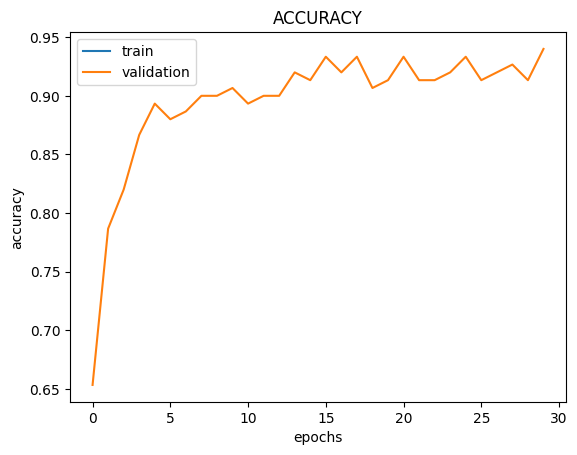

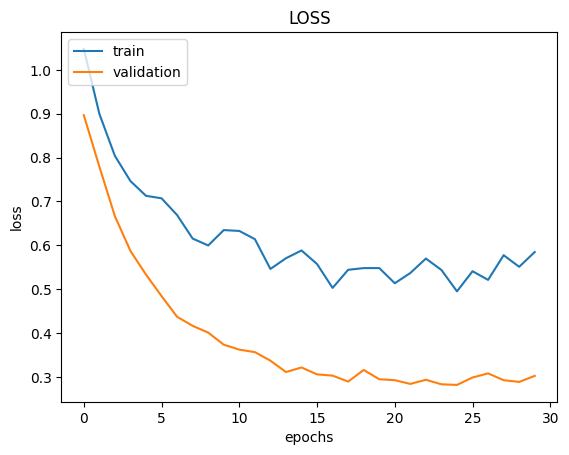

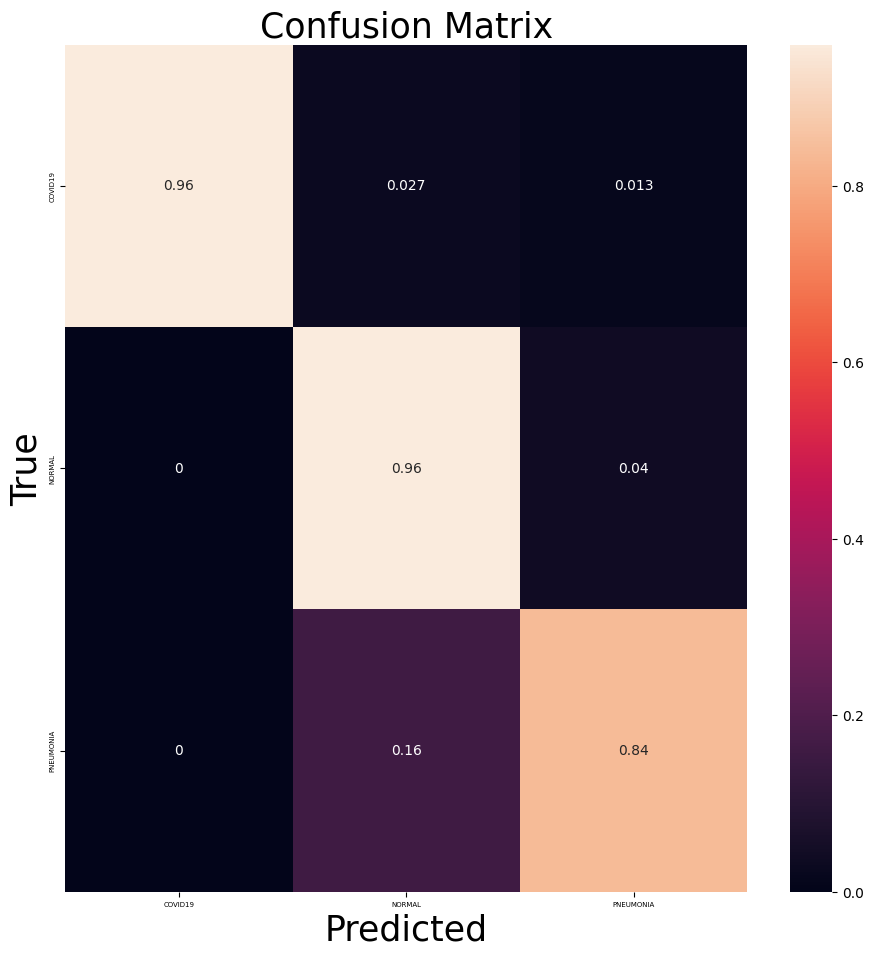

In [ ]:
net = torchvision.models.vit_b_16(pretrained=True)
net.heads.head = nn.Linear(768, 3)
model=net
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "vit_b_16_mix"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.000001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = run_training(
    train_loadervit, val_loadervit, model, 30, criterion, optimizer, scheduler, early_stopping, device,True)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loadervit, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loadervit, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

In [ ]:
batch_size=4
transform_IN =transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
    ])
train_loaderIN,val_loaderIN=get_DataLoader(transform_IN,batch_size)

transformIN_t =transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(brightness=0.25),
        #transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #AddGaussianNoise(),
        transforms.Resize((256, 256))
        ])
test_datasetIN = torchvision.datasets.ImageFolder(test_dir,transformIN_t)
test_loaderIN = torch.utils.data.DataLoader(test_datasetIN,batch_size,True)

In [ ]:
class Combind(nn.Module):
  def __init__(self):
    super().__init__()

    self.densenet=torchvision.models.densenet201(weights=torchvision.models.DenseNet201_Weights.DEFAULT)
    #self.VGG=torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
    #self.res=torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    #self.vit=torchvision.models.vit_b_16(pretrained=True)
    self.cls=nn.Linear(1000,3)
  def forward(self, i):
      x=self.densenet(i)
      #x=self.VGG(i)
      #x=torch.cat((x, self.VGG(i)), dim=1)
      #x=(x+self.res(i))/2
      #x=(x+self.vit(transforms.Resize((224, 224))(i)))/2
      return self.cls(x)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 57.8MB/s]


The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-Combind_dense_VGG-from-ImageNet.pt
Starting training with network:  Combind_dense_VGG
450/450: [===============================>] - ETA 0.6s
5.335 2.668 2.666
Epoch: 1
Training Loss: 1.165 => Validation Loss: 0.923, Validation Accuracy: 0.607 
450/450: [===============================>] - ETA 0.4s
5.765 2.668 3.096
Epoch: 2
Training Loss: 0.524 => Validation Loss: 0.418, Validation Accuracy: 0.847 
450/450: [===============================>] - ETA 0.4s
5.765 2.668 3.096
Epoch: 3
Training Loss: 0.257 => Validation Loss: 0.253, Validation Accuracy: 0.927 
450/450: [===============================>] - ETA 0.3s
5.765 2.668 3.096
Epoch: 4
Training Loss: 0.155 => Validation Loss: 0.205, Validation Accuracy: 0.933 
450/450: [===============================>] - ETA 0.3s
5.765 2.668 3.096
Epoch: 5
Training Loss: 0.108 => Validation Loss: 0.179, Validation Accuracy: 0.947 
450/450: [===============================>] - E

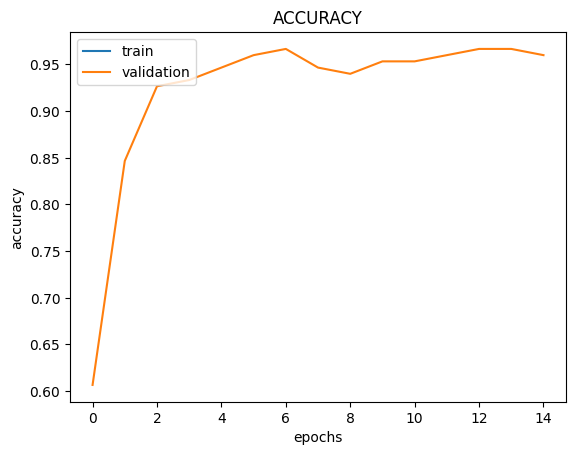

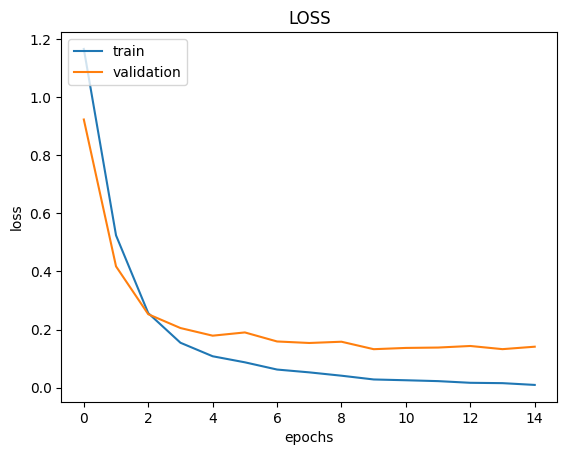

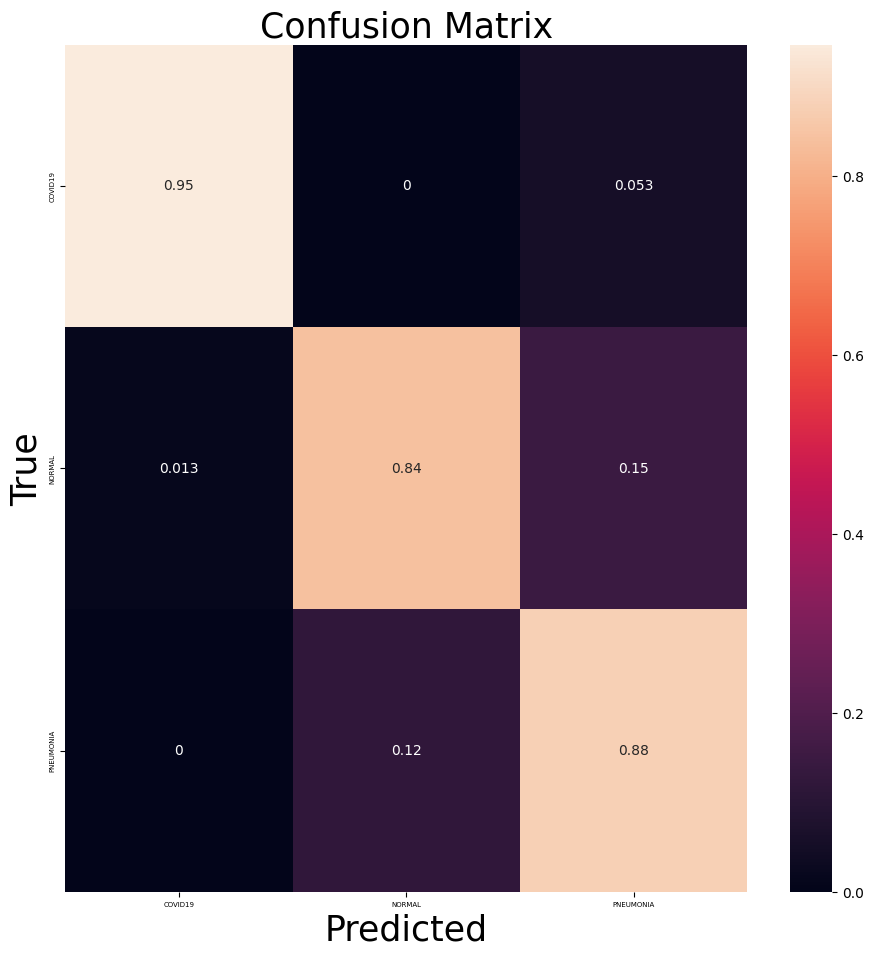

In [ ]:
#torch.cuda.empty_cache()
model=Combind()
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "Combind_dense_VGG"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.000001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = run_training(
    train_loaderIN, val_loaderIN, model, 30, criterion, optimizer, scheduler, early_stopping, device,b_transformer=False)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-DensnetMix-from-ImageNet.pt
Starting training from scratch with network:  DensnetMix
450/450: [==============================>.] - ETA 0.5s
Epoch: 1
Training Loss: 1.059 => Validation Loss: 1.078, Validation Accuracy: 0.467 
450/450: [==============================>.] - ETA 0.4s
Epoch: 2
Training Loss: 0.986 => Validation Loss: 0.925, Validation Accuracy: 0.653 
450/450: [==============================>.] - ETA 0.4s
Epoch: 3
Training Loss: 0.802 => Validation Loss: 0.762, Validation Accuracy: 0.813 
450/450: [==============================>.] - ETA 0.4s
Epoch: 4
Training Loss: 0.651 => Validation Loss: 0.636, Validation Accuracy: 0.860 
450/450: [==============================>.] - ETA 0.4s
Epoch: 5
Training Loss: 0.499 => Validation Loss: 0.496, Validation Accuracy: 0.893 
450/450: [==============================>.] - ETA 0.4s
Epoch: 6
Training Loss: 0.375 => Validation Loss: 0.395, Validation Accuracy: 0.907

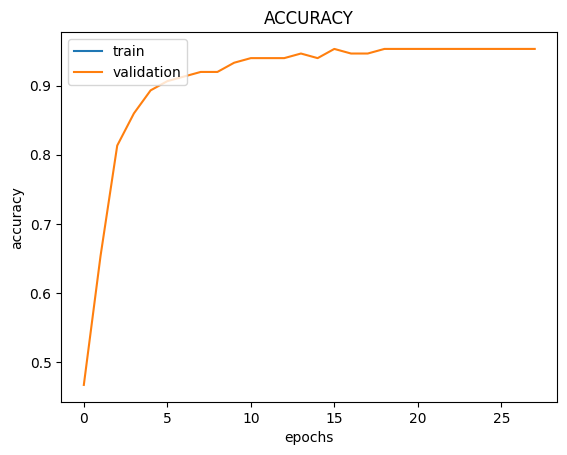

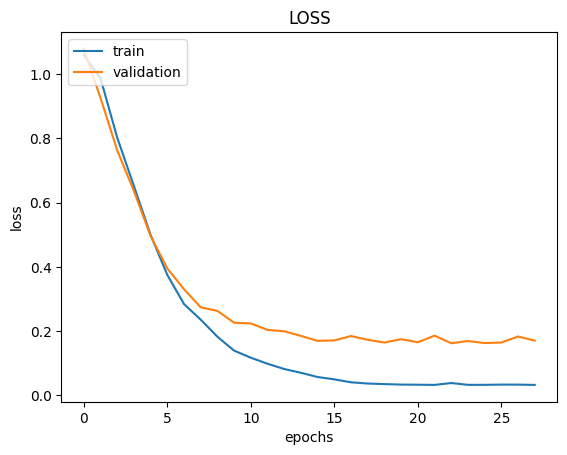

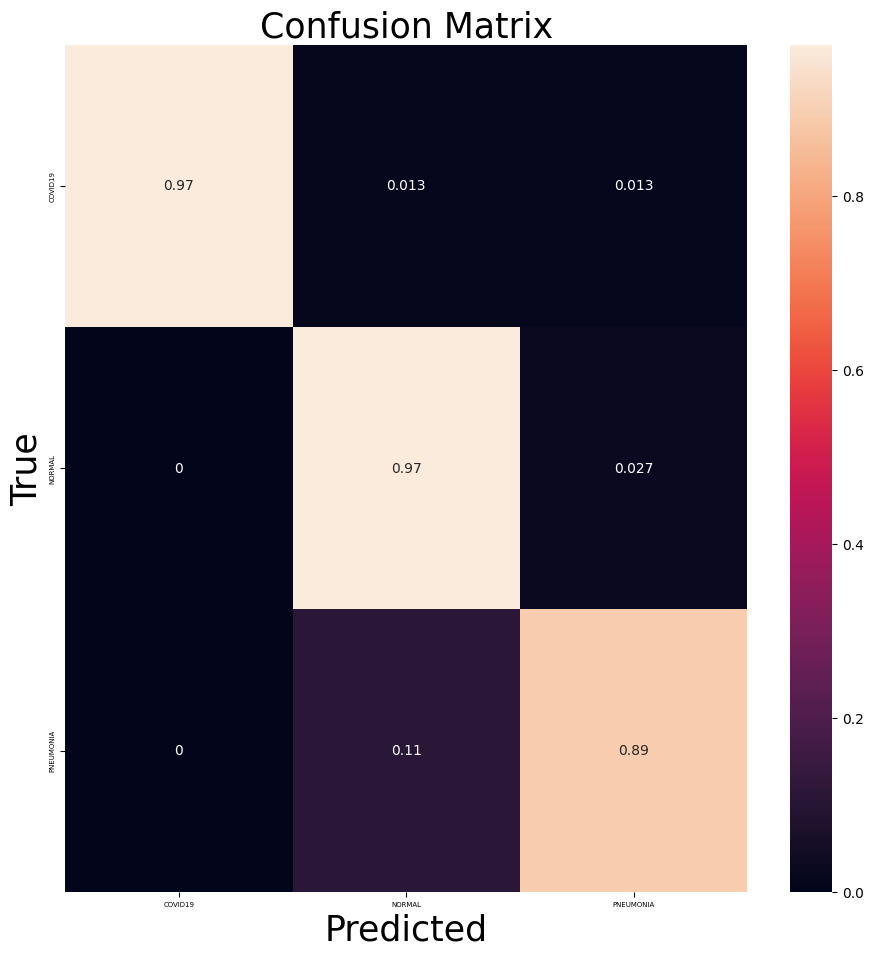

In [ ]:
model = torchvision.models.densenet201(weights=torchvision.models.DenseNet201_Weights.DEFAULT)

# Let's replace the "fully connected" layer to match our expected output classes
model.classifier = nn.Linear(model.classifier.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "DensnetMix"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.000001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = run_training(
    train_loaderIN, val_loaderIN, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

In [ ]:
correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

The model checkpoint will be saved here:  /content/drive/MyDrive/DL/covid-19-resnet50-from-ImageNet.pt
Starting training from scratch with network:  resnet50
450/450: [==============================>.] - ETA 0.3s
Epoch: 1
Training Loss: 1.101 , Training Accuracy:0.389 => Validation Loss: 1.091, Validation Accuracy: 0.413 
450/450: [==============================>.] - ETA 0.3s
Epoch: 2
Training Loss: 1.089 , Training Accuracy:0.438 => Validation Loss: 1.076, Validation Accuracy: 0.507 
450/450: [==============================>.] - ETA 0.4s
Epoch: 3
Training Loss: 1.061 , Training Accuracy:0.547 => Validation Loss: 1.047, Validation Accuracy: 0.547 
450/450: [==============================>.] - ETA 0.3s
Epoch: 4
Training Loss: 1.023 , Training Accuracy:0.640 => Validation Loss: 1.022, Validation Accuracy: 0.627 
450/450: [==============================>.] - ETA 0.3s
Epoch: 5
Training Loss: 0.987 , Training Accuracy:0.698 => Validation Loss: 0.993, Validation Accuracy: 0.660 
450/450: [==

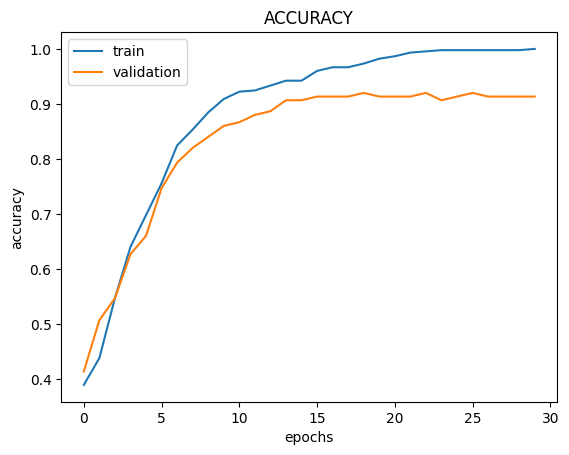

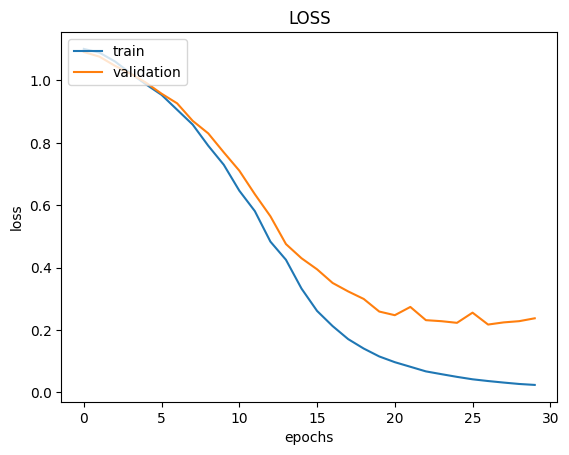

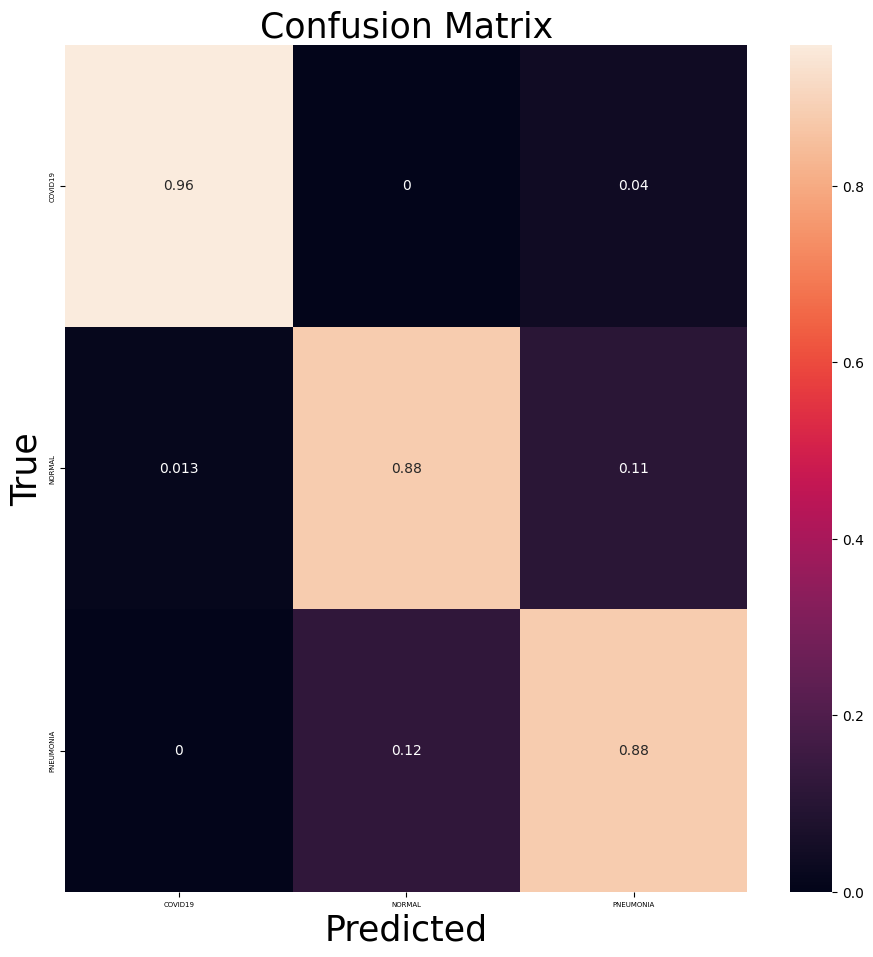

In [ ]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(model.fc.in_features, 3)
model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "resnet50"
checkpoint_name = f'covid-19-{model_name}-from-ImageNet.pt'
checkpoint_path = os.path.join(root_dirc, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(),lr=0.000001)  # optimizer
#scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=1, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=1)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(
    train_loaderIN, val_loaderIN, model, 30, criterion, optimizer, scheduler, early_stopping, device)


utils.get_metric_plots(accuracy, val_accuracy,"accuracy")
utils.get_metric_plots( losses, val_losses,"loss")
print(max(val_accuracy))

model.load_state_dict(torch.load(os.path.join(root_dirc, checkpoint_path)))
model.to(device)


correct, total = utils.test_evaluation(model, test_loaderIN, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loaderIN, model, device)
utils.check_precision_recall_accuracy(cm,classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

## Submission:

- The `unknown` set corresponds to a hold-out test set (with unlabeled images). Such unseen test data is common in machine learning challenges to ensure an objective comparison of different methods and to test how well these solutions would generalize to real data.
- Submit the predictons from your best model together with your exercise solution.
    - Upload the solutions to `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Challenge Results`.
    - Your submission should be called `Tutorial_X_Results_surname1_surname2_surname3.csv`. The expected file format is described below and we provide a function that generates these results for you already.
- **Please submit the results from your best model (or the model you expect to perform best). If you don't wor on the optional part of the exercise then submit the best result from the models you have trained so far.**
    - The group with the best submission will get a small prize ;-)

### Expected Submission Format

Before submitting your results, please make sure that they are in the below mentioned format:
- `Tutorial_X_Results_<surname1>_<surname2>_<surname3>.csv`
    - patient_\<ID-1>.jpg | \<CLASS-1>
    - patient_\<ID-2>.jpg | \<CLASS-2> <br>
    . <br>
    . <br>
    . <br>
    - patient_\<ID_n>.jpg | \<CLASS-[1-3]>

We have prepared a function that generates these predictions for you (see below).

In [ ]:
filename = "Tutorial_6_Dhameliya_Sayyad_Mogk_Sorathiya_Ex3.csv"

# Function generating predictions (in a csv file) for the respective images in the hold-out test set (`unknown` folder)
# Note: if you want to use test-time-augmentation or model ensembling you may need to update this function.
# If you don't want to update it you can also create a new class that implements a wrapper around the model(s)
# that implements the augmentation or ensembling logic.
utils.predict_unknown(model, height, width, train_dataset_mean, train_dataset_std, unknown_dir, device, filename)

# Download link is automatically generated for the final results generated
#!rm filename
FileLink(filename)

100%|██████████| 5607/5607 [04:33<00:00, 20.51it/s]


/content/Tutorial_6_Dhameliya_Sayyad_Mogk_Sorathiya_Ex3.csv